<a href="https://colab.research.google.com/github/QuanPhamAnh/Coursera_Capstone/blob/main/IBM%20DS/Applied%20Data%20Science%20Capstone%20Project/Week%204-5/Final%20Assignment%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>IBM Data Science Course Capstone Project<br>Starting A New Foreign Restaurant In Vietnam: What And Where To Start
</center>


## Introduction

This is my final effort for my first steps in Data Science career by finishing IBM Data Science Professional Certificate course. Here is my report for the capstone project of that course. I will use data science toolset I have learned on a real-life problem. I used Python to perform analysis and you can find the notebook at the end of the post for more information.

## Business Problem

Assume there is a businessman who wants to open a brand new restaurant in Vietnam. So, he wants to know where should he open his restaurant and what cuisine it would serves. Therefore, he as me to analyse and solve that problem



The assumption behind the analysis is that we use unsupervised machine learning, in this case is k-means cluster, to create clusters of pin location in two biggest city in Vietnam (Ha Noi and Ho Chi Minh City) and that will provide us with areas for consideration for the restaurant and which cuisine it should serve.

## Data

For this project, we need the following data:


1.   Information of restaurants in Ha Noi and Ho Chi Minh City: We can get this data from Foursquare like what we have learned. But in Vietnam, Foursquare data is not good as [Foody](https://foody.vn). <br><br>
Foody is a Vietnam-based company provides food recommendations, restaurant listings and value added services such as order delivery, reservations, vouchers or coupons to create culinary experiences for the customers in the local market. With more than 12,842,743 monthly web visitors, Foody.vn is ranked 16,868 among websites globally (March 7th, 2021). <br><br>
However, foody doesn't public there API (or I don't know where it is), so I have to crawl data using *requests* and *BeautifulSoup*.<br><br>
Data from Foody contain many features of restaurants we can use in our project: location, cuisine, rating, number of reviews, check in,...




2.   List of post location in Ha Noi and Ho Chi Minh City: postcode system in Vietnam is not very useful and I can't use geocode to get latitude and longitude from address. Therefore, I use data from [postcodequery](https://postcodequery.com) to get address and GPS coordinates of location.


## Web crawling for data

Import some libraries for our project

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from pandas import json_normalize
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="example app",timeout=None)
import re
!pip install unidecode
import unidecode
import json

     |████████████████████████████████| 245kB 8.4MB/s 


### Restaurant Data

Check 1 result page to know its pattern

In [ ]:
page = 1
city = 'ha-noi'
url = 'https://www.foody.vn/{}/nha-hang?ds=Restaurant&vt=row&st=5&c=1&page={}&categoryId=1&append=true'.format(city,page)
r = requests.get(url)
soup = BeautifulSoup(r.text,'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://www.facebook.com/2008/fbml">
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <title>
   Địa điểm Nhà hàng tại Hà Nội | Foody.vn
  </title>
  <meta content="text/html;charset=utf-8" http-equiv="Content-type"/>
  <meta content="Danh sách hơn 2,886 địa điểm Nhà hàng tại Hà Nội. Foody.vn là website #1 tại VN về tìm kiếm địa điểm, có hàng ngàn bình luận, hình ảnh" name="description"/>
  <meta content="Foody.vn là nơi chia sẻ và đánh giá địa điểm, với hàng ngàn địa điểm về ẩm thực, giải trí cùng hàng ngàn bình luận. Tham gia để chia sẻ trải nghiệm với cộng đồng" name="keywords"/>
  <meta content="app-id=1218739449" name="apple-itunes-app"/>
  <link href="/manifest.json" rel="manifest"/>
  <meta content="index, follow" name="robots">
   <meta content="9F288B3B53D32225CE6A70FA2DB2BF6D" name="msvalidate.01"/>
   <link href="/favicon.ico" rel="SHORTCUT ICON">
    <meta content="Địa điểm N

Found out that search results is in "jsonData" variables

In [ ]:
regex = re.compile("var jsonData = .*(?:\\r\\n)")
jsondata = regex.findall(soup.text)
jsondata[0]

'var jsonData = {"photoCollectionResultCount":8703,"provinceId":218,"categoryId":1,"districtId":0,"districtName":"Hà Nội","searchUrl":"/ha-noi/nha-hang","searchDefaultUrl":"/ha-noi/dia-diem","keyword":"","viewType":"row","sortType":5,"priceMin":0,"priceMax":5000000,"districts":[{"Id":20,"Avatar":null,"ParentId":0,"ParentName":null,"Name":"Quận Ba Đình","UrlRewriteName":null,"ResultCount":0,"Selected":false,"Min":null,"Max":null,"Children":[],"FilterType":2,"AsciiName":"Quan Ba Dinh"},{"Id":690,"Avatar":null,"ParentId":0,"ParentName":null,"Name":"Quận Bắc Từ Liêm","UrlRewriteName":null,"ResultCount":0,"Selected":false,"Min":null,"Max":null,"Children":[],"FilterType":2,"AsciiName":"Quan Bac Tu Liem"},{"Id":21,"Avatar":null,"ParentId":0,"ParentName":null,"Name":"Quận Cầu Giấy","UrlRewriteName":null,"ResultCount":0,"Selected":false,"Min":null,"Max":null,"Children":[],"FilterType":2,"AsciiName":"Quan Cau Giay"},{"Id":22,"Avatar":null,"ParentId":0,"ParentName":null,"Name":"Quận Đống Đa","Url

Get risk of variable's name and other symbols to make a formal json file

In [ ]:
jsondata = jsondata[0].replace('var jsonData =','').strip()
jsondata = jsondata[:-1]
results_json = json.loads(jsondata)

Read first result

In [ ]:
r1 = results_json['searchItems'][0]
r1

{'Address': '184 Hào Nam',
 'AdsProviders': [],
 'AlbumUrl': '/ha-noi/grille6-steakhouse/album-anh',
 'AvgRating': '7.5',
 'AvgRatingOriginal': 7.532,
 'BankCards': [],
 'BookingMobileUrl': 'https://www.now.vn/ha-noi/table/grille6-steakhouse',
 'BookingUrl': '/ha-noi/grille6-steakhouse',
 'BranchName': 'Hệ thống Botanica - Cafe & Resto',
 'BranchUrl': '/thuong-hieu/botanica-cafe-resto?c=ha-noi',
 'Categories': [{'ASCIIName': None,
   'DetailUrl': None,
   'Id': 1,
   'Name': 'Nhà hàng',
   'NameEn': None}],
 'CategoryGroupKey': None,
 'City': 'Hà Nội',
 'Cuisines': [{'ASCIIName': None,
   'DetailUrl': '/ha-noi/dia-diem-phong-cach-dong-au',
   'Id': 28,
   'Name': 'Đông Âu',
   'NameEn': None}],
 'DeliveryUrl': 'https://www.now.vn/ha-noi/grille6-steakhouse',
 'DetailUrl': '/ha-noi/grille6-steakhouse',
 'Distance': None,
 'District': 'Quận Đống Đa',
 'DistrictId': 22,
 'DistrictUrl': '/ha-noi/khu-vuc-quan-dong-da',
 'DocumentType': 0,
 'Floor': {'Avatar': 'https://images.foody.vn/default

In [ ]:
print('Name: ', r1['Name'],
      ', Address: ', r1['Address'], r1['District'],
      ', Rating: ', r1['AvgRating'],
      ', Cuisines: ', r1['Cuisines'][0]['Name'],
      ', Latitude: ', r1['Latitude'],
      ', Longitude: ', r1['Longitude'],
      ', Total Review: ', r1['TotalReview'])

Name:  Grille6 - Salad, Steak & Pasta - Hào Nam , Address:  184 Hào Nam Quận Đống Đa , Rating:  7.5 , Cuisines:  Đông Âu , Latitude:  21.028235 , Longitude:  105.827683 , Total Review:  448


If restaurant in is a branch, we can use SubItems to find other restaurants in branch

In [ ]:
len(r1['SubItems'])

4

In [ ]:
print(r1['SubItems'][0]['Name'], r1['SubItems'][0]['Address'], r1['SubItems'][0]['City'])

Botanica - Salad, Steak & Pasta - Thái Phiên 3 Thái Phiên Hà Nội


In [ ]:
r2 = results_json['searchItems'][1]
r2

{'Address': 'Tầng 1, AEON Mall Long Biên, 27 Cổ Linh',
 'AdsProviders': [],
 'AlbumUrl': '/ha-noi/food-court-aeon-mall-long-bien/album-anh',
 'AvgRating': '7.5',
 'AvgRatingOriginal': 7.482,
 'BankCards': [],
 'BookingMobileUrl': '',
 'BookingUrl': '',
 'BranchName': 'Hệ thống ',
 'BranchUrl': '',
 'Categories': [{'ASCIIName': None,
   'DetailUrl': None,
   'Id': 1,
   'Name': 'Nhà hàng',
   'NameEn': None}],
 'CategoryGroupKey': None,
 'City': 'Hà Nội',
 'Cuisines': [{'ASCIIName': None,
   'DetailUrl': '/ha-noi/dia-diem-phong-cach-quoc-te',
   'Id': 50,
   'Name': 'Quốc tế',
   'NameEn': None}],
 'DeliveryUrl': '',
 'DetailUrl': '/ha-noi/food-court-aeon-mall-long-bien',
 'Distance': None,
 'District': 'Quận Long Biên',
 'DistrictId': 27,
 'DistrictUrl': '/ha-noi/khu-vuc-quan-long-bien',
 'DocumentType': 0,
 'Floor': {'Avatar': 'https://images.foody.vn/default/s50/no-image.png',
  'Code': None,
  'Color': None,
  'Description': None,
  'DescriptionEn': None,
  'Id': 0,
  'Name': None,


In [ ]:
r2['SubItems'] == []

True

Define new functions to crawling data from web then create DataFrame

In [ ]:
def CreateDataframe(result):

    # create a placeholder
    temp_df = pd.DataFrame(columns = ['Name','Address','District','City','Rating', 'Total Review', 'Cuisine','Latitude','Longitude','Total Favourite'])
    
    # get relevant infomation
    name = result['Name']
    address = result['Address']
    district =  result['District']
    city = result['City']
    rating = result['AvgRating']
    try:
        cuisine = result['Cuisines'][0]['Name']
    except:
        cuisine = np.nan
    latitude = result['Latitude']
    longitude = result['Longitude']
    count = result['TotalFavourite']
    review = result['TotalReview']
    # add data into placeholder
    temp_df = temp_df.append({'Name':name,
                              'Address':address,
                              'District':district,
                              'City':city,
                              'Rating':rating,
                              'Total Review' : review,
                              'Cuisine':cuisine,
                              'Latitude':latitude,
                              'Longitude':longitude,
                              'Total Favourite':count
                              }, ignore_index=True)
    
    return temp_df

In [ ]:
def GetRestaurantInfo(city,page):

    # create a placeholder dataframe
    temp_restaurant_df = pd.DataFrame(columns = ['Name','Address','District','City','Rating', 'Total Review', 'Cuisine','Latitude','Longitude','Total Favourite'])

    # request results page
    url = 'https://www.foody.vn/{}/nha-hang?ds=Restaurant&vt=row&st=5&c=1&page={}&categoryId=1&append=true'.format(city,page)    
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    # extract results from soup and load as a json
    regex = re.compile("var jsonData = .*(?:\\r\\n)")
    jsondata = regex.findall(soup.text)
    jsondata = jsondata[0].replace('var jsonData =','').strip()
    jsondata = jsondata[:-1]
    results_json = json.loads(jsondata)
    results = results_json['searchItems']

    # get relevant infomation for each restaurant from results
    results = results_json['searchItems']
    for result in results:
        temp_restaurant_df = temp_restaurant_df.append(CreateDataframe(result),ignore_index = True)
    
    # If it's a branch of restaurants, we will need to check for its subItems
        if result['SubItems'] != []:
            for i in range(len(result['SubItems'])):
                r = result['SubItems'][i]
                temp_restaurant_df = temp_restaurant_df.append(CreateDataframe(r),ignore_index = True)
    return temp_restaurant_df

Using new defined function to crawling data needed for our project

In [ ]:
restaurant_df = pd.DataFrame(columns = ['Name','Address','District','City','Rating', 'Total Review', 'Cuisine','Latitude','Longitude','Total Favourite'])
cities = ['ha-noi','ho-chi-minh']

for city in cities:
    page = 1
    number_of_results = 12
    while number_of_results >= 12:
        sub_result = GetRestaurantInfo(city,page)
        number_of_results = len(sub_result)
        restaurant_df = restaurant_df.append(sub_result,ignore_index = True)
        page += 1

In [ ]:
restaurant_df

,Name,Address,District,City,Rating,Total Review,Cuisine,Latitude,Longitude,Total Favourite
0,"Grille6 - Salad, Steak & Pasta - Hào Nam",184 Hào Nam,Quận Đống Đa,Hà Nội,7.5,448,Đông Âu,21.028235,105.827683,485
1,"Botanica - Salad, Steak & Pasta - Thái Phiên",3 Thái Phiên,Quận Hai Bà Trưng,Hà Nội,7.4,381,Châu Mỹ,21.010549,105.851308,323
2,"Botanica - Salad, Steak & Pasta - Giảng Võ",116 D4 Giảng Võ,Quận Ba Đình,Hà Nội,7.3,276,Pháp,21.026040,105.822366,268
3,"Grille6 - Salad, Steak & Pasta - Lê Văn Hưu",21 Lê Văn Hưu,Quận Hai Bà Trưng,Hà Nội,6.5,3,Món Âu,21.018009,105.853876,5
4,"Botanica Salad, Steak & Pasta - Trung Hòa",54 Trung Hòa,Quận Cầu Giấy,Hà Nội,6.1,2,NaN,21.015020,105.801503,6
...,...,...,...,...,...,...,...,...,...,...
5638,Saigon Green House - Halal Restaurant,"52 Trương Định, P. Bến Thành",Quận 1,TP. HCM,2.0,2,Malaysia,10.772538,106.695879,2
5639,Food Court - An Đông Plaza,"18 An Dương Vương, P. 8",Quận 5,TP. HCM,5.9,2,Món Việt,10.757164,106.673248,0
5640,Nhà Hàng Sentosa Palace,"116A Nguyễn Hữu Thọ, P. Phước Kiển",Huyện Nhà Bè,TP. HCM,3.8,2,Món Việt,10.718568,106.702061,0
5641,Nhà Hàng Khách Sạn Gió Lộng - Tắc Xuất,Tắc Xuất,Huyện Cần Giờ,TP. HCM,7.3,2,Món Việt,10.412455,106.963489,0


In [ ]:
restaurant_df['Total Favourite'] = pd.to_numeric(restaurant_df['Total Favourite'])
restaurant_df['Total Review'] = pd.to_numeric(restaurant_df['Total Review'])
restaurant_df['Rating'].replace('_._',np.nan, inplace = True)
restaurant_df.dropna(inplace = True)
restaurant_df['Rating'] = pd.to_numeric(restaurant_df['Rating'])
restaurant_df

,Name,Address,District,City,Rating,Total Review,Cuisine,Latitude,Longitude,Total Favourite
0,"Grille6 - Salad, Steak & Pasta - Hào Nam",184 Hào Nam,Quận Đống Đa,Hà Nội,7.5,448,Đông Âu,21.028235,105.827683,485
1,"Botanica - Salad, Steak & Pasta - Thái Phiên",3 Thái Phiên,Quận Hai Bà Trưng,Hà Nội,7.4,381,Châu Mỹ,21.010549,105.851308,323
2,"Botanica - Salad, Steak & Pasta - Giảng Võ",116 D4 Giảng Võ,Quận Ba Đình,Hà Nội,7.3,276,Pháp,21.026040,105.822366,268
3,"Grille6 - Salad, Steak & Pasta - Lê Văn Hưu",21 Lê Văn Hưu,Quận Hai Bà Trưng,Hà Nội,6.5,3,Món Âu,21.018009,105.853876,5
5,Food Court - AEON Mall Long Biên,"Tầng 1, AEON Mall Long Biên, 27 Cổ Linh",Quận Long Biên,Hà Nội,7.5,442,Quốc tế,21.026996,105.898464,136
...,...,...,...,...,...,...,...,...,...,...
5638,Saigon Green House - Halal Restaurant,"52 Trương Định, P. Bến Thành",Quận 1,TP. HCM,2.0,2,Malaysia,10.772538,106.695879,2
5639,Food Court - An Đông Plaza,"18 An Dương Vương, P. 8",Quận 5,TP. HCM,5.9,2,Món Việt,10.757164,106.673248,0
5640,Nhà Hàng Sentosa Palace,"116A Nguyễn Hữu Thọ, P. Phước Kiển",Huyện Nhà Bè,TP. HCM,3.8,2,Món Việt,10.718568,106.702061,0
5641,Nhà Hàng Khách Sạn Gió Lộng - Tắc Xuất,Tắc Xuất,Huyện Cần Giờ,TP. HCM,7.3,2,Món Việt,10.412455,106.963489,0


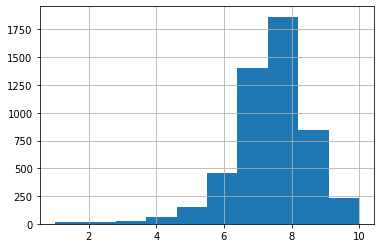

In [ ]:
restaurant_df['Rating'].hist()

Raw data we get have a lot of restaurants have high rating (9-10), which is unusual, maybe because they don't have many reviews. We filter dataframe with 'Total Review' >= 5 to filter out some unpopular restaurants

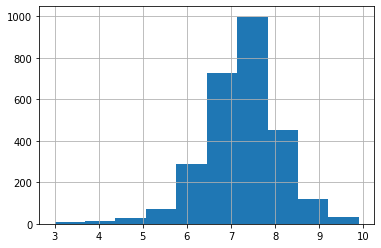

In [ ]:
restaurant_df[restaurant_df['Total Review'] >= 10]['Rating'].hist()

In [ ]:
filtered_restaurant_df = restaurant_df[restaurant_df['Total Review'] >= 10].drop(columns=['Address'])
filtered_restaurant_df.reset_index(drop = True, inplace = True)
filtered_restaurant_df

,Name,District,City,Rating,Total Review,Cuisine,Latitude,Longitude,Total Favourite
0,"Grille6 - Salad, Steak & Pasta - Hào Nam",Quận Đống Đa,Hà Nội,7.5,448,Đông Âu,21.028235,105.827683,485
1,"Botanica - Salad, Steak & Pasta - Thái Phiên",Quận Hai Bà Trưng,Hà Nội,7.4,381,Châu Mỹ,21.010549,105.851308,323
2,"Botanica - Salad, Steak & Pasta - Giảng Võ",Quận Ba Đình,Hà Nội,7.3,276,Pháp,21.026040,105.822366,268
3,Food Court - AEON Mall Long Biên,Quận Long Biên,Hà Nội,7.5,442,Quốc tế,21.026996,105.898464,136
4,Gà Rán Popeyes - AEON Mall Long Biên,Quận Long Biên,Hà Nội,7.2,84,Châu Mỹ,21.026516,105.900099,14
...,...,...,...,...,...,...,...,...,...
2733,Saigon Social Space - Nhà Hàng Á Âu,Quận 2,TP. HCM,8.4,10,Món Âu,10.763068,106.759421,13
2734,The Organic Bistro,Quận 1,TP. HCM,9.7,10,Món Việt,10.791528,106.693469,8
2735,Stirling Steaks Vietnam - Nguyễn Gia Trí,Quận Bình Thạnh,TP. HCM,8.6,10,Quốc tế,10.803256,106.715774,29
2736,Pizza Tonda Vietnam - Vincom Mega Mall,Quận 2,TP. HCM,6.1,10,Ý,10.802393,106.738793,7


### Neighborhoods (pins) Data

Define new function to get pin location from website *postcodequery.com*

In [ ]:
def GetPinLocation(id):
    
    # create temporary DataFrame to store infomation
    temp_pin_df = pd.DataFrame(columns = ['Pin','Latitude','Longitude'])

    threshold = 10
    p = 1

    # while loop to get to other results pages until number of result in a page is less than 10
    while threshold == 10:
        # get results page for each location id 
        url = 'http://vnm.postcodequery.com/list/{}/p{}'.format(id,p)
        r = requests.get(url)
        soup = BeautifulSoup(r.text,'html.parser')
        
        # because all results page doesn't contain infomation we need, we need to find 'html' of each result and get in there
        results = soup.find_all('a', {'class':'f14'})
        regex = re.compile('\/\w+==.html')
        page_list = regex.findall(str(results))
        threshold = len(page_list)
        p += 1

        # get in each result page to find infomation about location
        for page in page_list:
            url = 'http://vnm.postcodequery.com'+str(page)
            r = requests.get(url)
            soup = BeautifulSoup(r.text,'html.parser')
            infos = soup.find_all('span', {'class':"green"})
            for info in infos:
                if 'Title' in str(info):
                    title = info.next_element.next_element
                    title = re.sub(r',[\s\w]+$|, .00000','',title)
                if 'Latitude' in str(info):
                    lat = info.next_element.next_element
                if 'Longitude' in str(info):
                    lng = info.next_element.next_element
            pin = title+' ('+lat+', '+lng+')'
            # add infomation to final DataFrame
            temp_pin_df = temp_pin_df.append({'Pin':unidecode.unidecode(pin),'Latitude':lat,'Longitude':lng},ignore_index=True)
    
    return temp_pin_df

Crawling pins location information and add to dataframe

In [ ]:
pin_df = pd.DataFrame(columns = ['Pin','Latitude','Longitude'])

ids = [26,32]
for id in ids:
    pin_df = pin_df.append(GetPinLocation(id),ignore_index=True)           

In [ ]:
pin_df.dropna(inplace = True)
pin_df.drop_duplicates(subset=['Latitude','Longitude'],inplace=True)
pin_df['Latitude'] = pd.to_numeric(pin_df['Latitude'])
pin_df['Longitude'] = pd.to_numeric(pin_df['Longitude'])
pin_df

,Pin,Latitude,Longitude
0,"Cong Vi, Ba Dinh, Ha Noi (21.03482, 105.80894)",21.03482,105.80894
1,"Giang Vo, Ba Dinh, Ha Noi (21.02755, 105.81743)",21.02755,105.81743
2,"Kim Ma, Ba Dinh, Ha Noi (21.03080, 105.82352)",21.03080,105.82352
3,"Lieu Giai, Ba Dinh, Ha Noi (21.03836, 105.81676)",21.03836,105.81676
4,"Ngoc Ha, Ba Dinh, Ha Noi (21.03872, 105.82751)",21.03872,105.82751
...,...,...,...
543,"Linh Xuan, Thu Duc, Ho Chi Minh (10.88122, 106...",10.88122,106.77054
544,"Linh Dong, Thu Duc, Ho Chi Minh (10.84699, 106...",10.84699,106.74566
545,"Tam Binh, Thu Duc, Ho Chi Minh (10.86681, 106....",10.86681,106.73578
546,"Tam Phu, Thu Duc, Ho Chi Minh (10.85729, 106.7...",10.85729,106.74028


Pins in Ha Noi

In [ ]:
hn_pin_df = pin_df[pin_df['Pin'].str.contains('Ha Noi')]
hn_pin_df

,Pin,Latitude,Longitude
0,"Cong Vi, Ba Dinh, Ha Noi (21.03482, 105.80894)",21.03482,105.80894
1,"Giang Vo, Ba Dinh, Ha Noi (21.02755, 105.81743)",21.02755,105.81743
2,"Kim Ma, Ba Dinh, Ha Noi (21.03080, 105.82352)",21.03080,105.82352
3,"Lieu Giai, Ba Dinh, Ha Noi (21.03836, 105.81676)",21.03836,105.81676
4,"Ngoc Ha, Ba Dinh, Ha Noi (21.03872, 105.82751)",21.03872,105.82751
...,...,...,...
226,"Trung Liet, Dong Da, Ha Noi (21.01098, 105.82217)",21.01098,105.82217
227,"Trung Phong, Dong Da, Ha Noi (21.01644, 105.83...",21.01644,105.83767
228,"Trung Tu, Dong Da, Ha Noi (21.00654, 105.83187)",21.00654,105.83187
229,"Van Chuong, Dong Da, Ha Noi (21.02384, 105.83522)",21.02384,105.83522


Pins in Ho Chi Minh City

In [ ]:
hcmc_pin_df = pin_df[pin_df['Pin'].str.contains('Ho Chi Minh')]
hcmc_pin_df

,Pin,Latitude,Longitude
231,"An Phu Tay, Binh Chanh, Ho Chi Minh (10.68722,...",10.68722,106.60768
232,"Binh Chanh, Binh Chanh, Ho Chi Minh (10.66430,...",10.66430,106.56640
233,"Binh Hung, Binh Chanh, Ho Chi Minh (10.71673, ...",10.71673,106.67031
234,"Binh Loi, Binh Chanh, Ho Chi Minh (10.75234, 1...",10.75234,106.49948
235,"Hung Long, Binh Chanh, Ho Chi Minh (10.66622, ...",10.66622,106.62546
...,...,...,...
543,"Linh Xuan, Thu Duc, Ho Chi Minh (10.88122, 106...",10.88122,106.77054
544,"Linh Dong, Thu Duc, Ho Chi Minh (10.84699, 106...",10.84699,106.74566
545,"Tam Binh, Thu Duc, Ho Chi Minh (10.86681, 106....",10.86681,106.73578
546,"Tam Phu, Thu Duc, Ho Chi Minh (10.85729, 106.7...",10.85729,106.74028


Using folium to visualize pin map

In [ ]:
map_hn = folium.Map(location=[21.154, 105.829], zoom_start=11)
import folium
# add markers to map
for lat, lng, pin in zip(hn_pin_df['Latitude'], hn_pin_df['Longitude'], hn_pin_df['Pin']):
    label = pin
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hn)  
 
map_hcmc = folium.Map(location=[10.783, 106.697], zoom_start=11)

# add markers to map
for lat, lng, pin in zip(hcmc_pin_df['Latitude'], hcmc_pin_df['Longitude'], hcmc_pin_df['Pin']):
    label = pin
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hcmc)  
    

In [ ]:
map_hn

In [ ]:
map_hcmc

## Analysis

### Exploratory data analysis 

First, we check some information from out data

In [ ]:
filtered_restaurant_df['City'].value_counts()

TP. HCM    1816
Hà Nội      922
Name: City, dtype: int64

Look like there is more restaurants in Ho Chi Minh City (at least on Foody) than Hanoi (2.3 times)

In [ ]:
pd.pivot_table(filtered_restaurant_df, index = 'City', aggfunc={'Rating':np.mean, 'Total Review':np.sum})

,Rating,Total Review
City,,
Hà Nội,7.238069,42370
TP. HCM,7.263932,126852


People in Ho Chi Minh post their reviews on Foody more often. <br> Average rating of restaurants in  both city is the same.

Let's look at restaurants by district in both city



In [ ]:
restaurant_by_district = filtered_restaurant_df.groupby(['City','District'])['Name'].count()
print('Hà Nội \n\n', restaurant_by_district['Hà Nội'].sort_values(ascending = False), '\n\nTP.HCM \n\n', restaurant_by_district['TP. HCM'].sort_values(ascending = False))

Hà Nội 

 District
Quận Cầu Giấy        151
Quận Hoàn Kiếm       140
Quận Đống Đa         136
Quận Hai Bà Trưng    135
Quận Ba Đình         130
Quận Thanh Xuân       65
Quận Nam Từ Liêm      38
Quận Long Biên        38
Quận Tây Hồ           37
Quận Hoàng Mai        23
Quận Hà Đông          19
Quận Bắc Từ Liêm       7
Huyện Sóc Sơn          2
Huyện Đông Anh         1
Name: Name, dtype: int64 

TP.HCM 

 District
Quận 1              567
Quận 3              174
Quận 7              153
Quận Bình Thạnh     114
Quận Tân Bình       104
Quận 10             104
Quận 2               95
Quận Gò Vấp          78
Quận Phú Nhuận       76
Quận Tân Phú         70
Quận 5               70
Quận Thủ Đức         51
Quận Bình Tân        37
Quận 11              26
Quận 6               18
Quận 4               17
Quận 8               17
Quận 9               15
Quận 12              11
Huyện Hóc Môn         7
Huyện Nhà Bè          5
Huyện Bình Chánh      5
Huyện Củ Chi          2
Name: Name, dtype: int64


In Ha Noi, restaurants are centralized in 5 district: Cau Giay, Hoan Kiem, Dong Da, Ba Dinh, Hai Ba Trung. District which have less than 10 restaurants may be dropped out because we filter out neighborhoods which less than 3 restaurants in 1 km radius. <br>
In Ho Chi Minh, 1/3 restaurants is in District 1, which is the center of the city. District 3, 7 have more than 100 restaurants. Many towns on the outskirt of the city will be dropped out too.

Then we count our restaurants by cuisines


In [ ]:
filtered_restaurant_df['Cuisine'].value_counts()

Món Việt          854
Món Nhật          455
Món Hàn           342
Châu Mỹ           172
Món Trung Hoa     144
Ý                 132
Món Âu            122
Món Á             116
Quốc tế           114
Món Thái           84
Pháp               54
Món Bắc            37
Singapore          24
Món Miền Trung     22
Món Ấn Độ          21
Món Miền Nam       20
Đức                 7
Trung Đông          4
Đông Âu             4
Mỹ                  4
Malaysia            1
Brazil              1
Úc                  1
Món Quảng           1
Philippines         1
Bắc Âu              1
Name: Cuisine, dtype: int64

Grouping some minor cuisines (< 40 index) into bigger group and translate into English

In [ ]:
filtered_restaurant_df['Cuisine'].replace({'Món Việt':'Vietnamese',
                                       'Món Nhật':'Japanese',
                                       'Món Hàn':'Korean',
                                       'Châu Mỹ':'American',
                                       'Món Trung Hoa':'Chinese',
                                       'Ý':'Italian',
                                       'Món Âu':'Western',
                                       'Món Á':'Asian',
                                       'Quốc tế':'International',
                                       'Món Thái':'Thai',
                                       'Pháp':'French',
                                       'Món Bắc':'Vietnamese',
                                       'Singapore':'Asian',
                                       'Món Miền Nam':'Vietnamese',
                                       'Món Miền Trung':'Vietnamese',
                                       'Món Ấn Độ':'International',
                                       'Hà Nội':'Vietnamese',
                                       'Đức':'Western',
                                       'Mỹ':'American',
                                       'Đông Âu':'Western',
                                       'Trung Đông':'International',
                                       'Malaysia':'Asian',
                                       'Úc':'Western',
                                       'Philippines':'Asian',
                                       'Món Quảng':'Vietnamese',
                                       'Brazil':'American',
                                       'Bắc Âu':'Western'
                                       }, inplace = True)

Now we count restaurants by cuisines, again

In [ ]:
filtered_restaurant_df['Cuisine'].value_counts()

Vietnamese       934
Japanese         455
Korean           342
American         177
Chinese          144
Asian            142
International    139
Western          135
Italian          132
Thai              84
French            54
Name: Cuisine, dtype: int64

Of course Vietnamese's restaurants will be majority. I will filter out Vietnamese cuisine restaurant because I want foreign cuisine restaurant only. <br>
Japanese's and Korean's restaurants are almost a half of the rest restaurants.

In [ ]:
filtered_restaurant_df = filtered_restaurant_df[filtered_restaurant_df['Cuisine'] != 'Vietnamese']

In [ ]:
cuisine_df = filtered_restaurant_df[['Name','City','Cuisine']].groupby(by=['City','Cuisine']).count()
cuisine_df

Name
City    Cuisine            
Hà Nội  American         52
        Asian            70
        Chinese          32
        French           19
        International    92
        Italian          49
        Japanese        130
        Korean          149
        Thai             27
        Western          26
TP. HCM American        125
        Asian            72
        Chinese         112
        French           35
        International    47
        Italian          83
        Japanese        325
        Korean          193
        Thai             57
        Western         109

In [ ]:
cuisine_pcts = cuisine_df.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
cuisine_pcts.rename(columns = {'Name':'Pcts'}, inplace = True)
cuisine_pcts

Pcts
City    Cuisine                 
Hà Nội  American        8.049536
        Asian          10.835913
        Chinese         4.953560
        French          2.941176
        International  14.241486
        Italian         7.585139
        Japanese       20.123839
        Korean         23.065015
        Thai            4.179567
        Western         4.024768
TP. HCM American       10.794473
        Asian           6.217617
        Chinese         9.671848
        French          3.022453
        International   4.058722
        Italian         7.167530
        Japanese       28.065630
        Korean         16.666667
        Thai            4.922280
        Western         9.412781

Text(0.5, 0.98, 'Percentage of Cuisines')

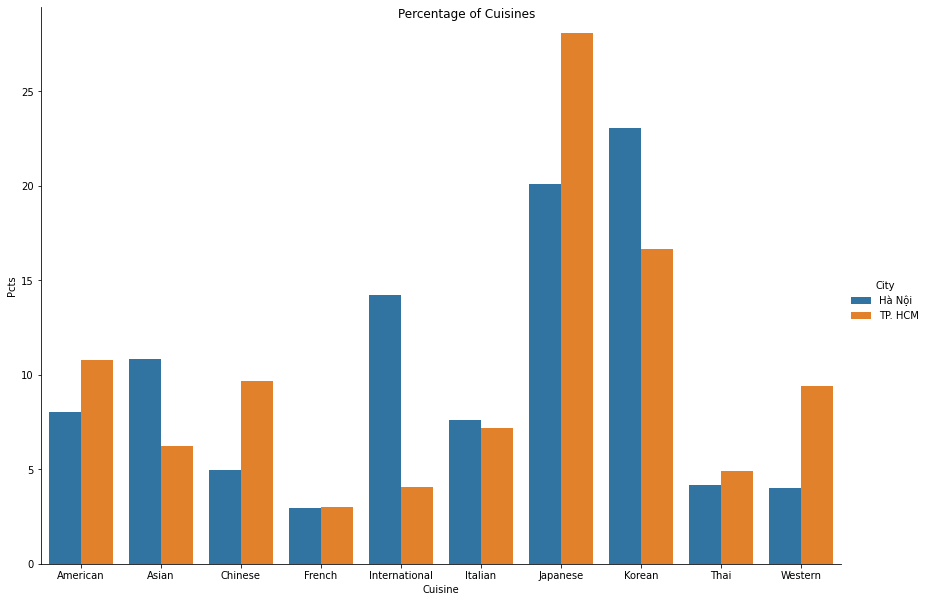

In [ ]:
ax = sns.catplot(data = cuisine_pcts.reset_index(), x = 'Cuisine', y = 'Pcts', hue = 'City', kind = 'bar', height=8.27, aspect=11.7/8.27)
ax.fig.suptitle('Percentage of Cuisines')

Japanese's restaurants is majority in Ho Chi Minh city (28.6 %) but restaurants in Ha Noi serve more Korean cuisines than the rest (24.0%). <br>
We can see that restaurants in Ha Noi are more diverse, maybe because Ha Noi have lots of diplomatic missions for many countries.

In [ ]:
rating_df = filtered_restaurant_df[['Rating','City','Cuisine']].groupby(by=['City','Cuisine']).mean()
rating_df

Rating
City    Cuisine                
Hà Nội  American       7.246154
        Asian          7.297143
        Chinese        7.315625
        French         7.742105
        International  7.502174
        Italian        7.197959
        Japanese       7.518462
        Korean         7.088591
        Thai           6.703704
        Western        7.296154
TP. HCM American       6.952000
        Asian          7.236111
        Chinese        7.401786
        French         7.440000
        International  7.697872
        Italian        7.466265
        Japanese       7.502769
        Korean         7.202073
        Thai           7.447368
        Western        7.440367

Text(0.5, 0.98, 'Rating per Cuisine')

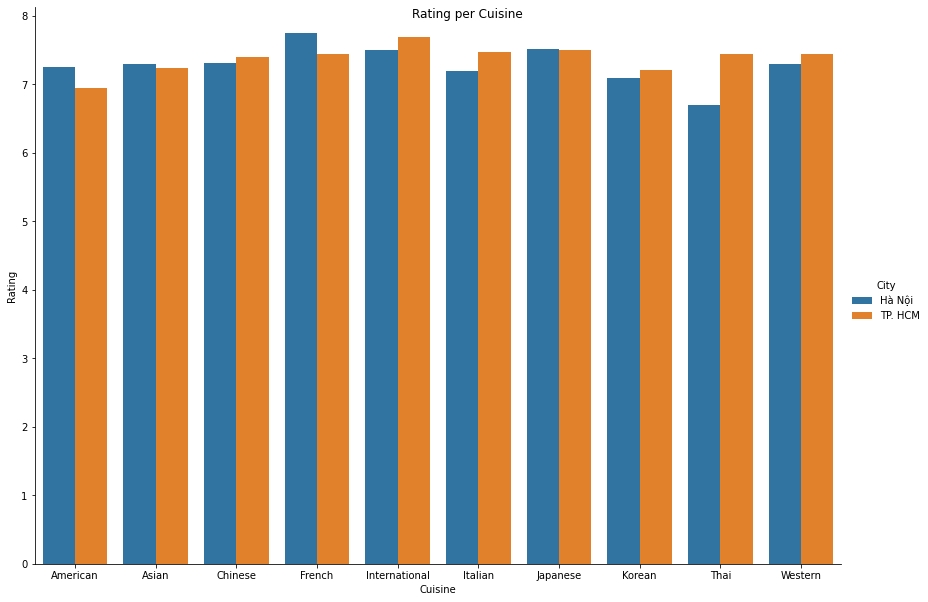

In [ ]:
ax = sns.catplot(data = rating_df.reset_index(), x = 'Cuisine', y = 'Rating', hue = 'City', kind = 'bar', height=8.27, aspect=11.7/8.27)
ax.fig.suptitle('Rating per Cuisine')

Rating of every cuisines is around 7.0, we didn't get much info from this

### Merge Restaurants and Pins Data

Define function to calculate distance (km) from pins to restaurants

In [ ]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

def calculate_distance(lat1,lng1,lat2,lng2):
    lat1 = radians(lat1)
    lng1 = radians(lng1)
    lat2 = radians(lat2)
    lng2 = radians(lng2)

    dlat = lat2 - lat1
    dlng = lng2 - lng1
  
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlng / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c * 1000

    return distance

In [ ]:
# Test calculator
calculate_distance(10.781878,106.705055,10.776159,106.705537)

638.2999257098824

In [ ]:
filtered_restaurant_df['Nearest pin'] = 0
filtered_restaurant_df['Distance'] = 0
filtered_restaurant_df.reset_index(drop=True,inplace=True)
filtered_restaurant_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Name,District,City,Rating,Total Review,Cuisine,Latitude,Longitude,Total Favourite,Nearest pin,Distance
0,"Grille6 - Salad, Steak & Pasta - Hào Nam",Quận Đống Đa,Hà Nội,7.5,448,Western,21.028235,105.827683,485,0,0
1,"Botanica - Salad, Steak & Pasta - Thái Phiên",Quận Hai Bà Trưng,Hà Nội,7.4,381,American,21.010549,105.851308,323,0,0
2,"Botanica - Salad, Steak & Pasta - Giảng Võ",Quận Ba Đình,Hà Nội,7.3,276,French,21.026040,105.822366,268,0,0
3,Food Court - AEON Mall Long Biên,Quận Long Biên,Hà Nội,7.5,442,International,21.026996,105.898464,136,0,0
4,Gà Rán Popeyes - AEON Mall Long Biên,Quận Long Biên,Hà Nội,7.2,84,American,21.026516,105.900099,14,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1799,Pou Pizza - Quang Trung,Quận 9,TP. HCM,8.8,10,Italian,10.836122,106.771735,5,0,0
1800,Dê Ngô Đồng Restaurant,Quận 10,TP. HCM,8.5,10,Chinese,10.768715,106.668306,12,0,0
1801,Saigon Social Space - Nhà Hàng Á Âu,Quận 2,TP. HCM,8.4,10,Western,10.763068,106.759421,13,0,0
1802,Stirling Steaks Vietnam - Nguyễn Gia Trí,Quận Bình Thạnh,TP. HCM,8.6,10,International,10.803256,106.715774,29,0,0


Calculate distance from restaurant to pins and add pins to restaurant dataframe

In [ ]:
for row in range(len(filtered_restaurant_df)):
    
    min_distance = 1000
    i = ''
    status = 'Not in range'

    lat1 = filtered_restaurant_df.iloc[row]['Latitude']
    lng1 = filtered_restaurant_df.iloc[row]['Longitude']


    for pin in range(len(pin_df)):
        lat2 = pin_df.iloc[pin]['Latitude']
        lng2 = pin_df.iloc[pin]['Longitude']

        distance = calculate_distance(lat1,lng1,lat2,lng2)

        if distance < min_distance:
            status = 'In range of a pin'
            i = i + (pin_df.iloc[pin]['Pin']) +';'

    filtered_restaurant_df.loc[row,'Nearest pin'] = str(i)
    filtered_restaurant_df.loc[row,'Distance'] = status      

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
filtered_restaurant_df

,Name,District,City,Rating,Total Review,Cuisine,Latitude,Longitude,Total Favourite,Nearest pin,Distance
0,"Grille6 - Salad, Steak & Pasta - Hào Nam",Quận Đống Đa,Hà Nội,7.5,448,Western,21.028235,105.827683,485,"Kim Ma, Ba Dinh, Ha Noi (21.03080, 105.82352);...",In range of a pin
1,"Botanica - Salad, Steak & Pasta - Thái Phiên",Quận Hai Bà Trưng,Hà Nội,7.4,381,American,21.010549,105.851308,323,"Bach Khoa, Hai Ba Trung, Ha Noi (21.00438, 105...",In range of a pin
2,"Botanica - Salad, Steak & Pasta - Giảng Võ",Quận Ba Đình,Hà Nội,7.3,276,French,21.026040,105.822366,268,"Giang Vo, Ba Dinh, Ha Noi (21.02755, 105.81743...",In range of a pin
3,Food Court - AEON Mall Long Biên,Quận Long Biên,Hà Nội,7.5,442,International,21.026996,105.898464,136,,Not in range
4,Gà Rán Popeyes - AEON Mall Long Biên,Quận Long Biên,Hà Nội,7.2,84,American,21.026516,105.900099,14,,Not in range
...,...,...,...,...,...,...,...,...,...,...,...
1799,Pou Pizza - Quang Trung,Quận 9,TP. HCM,8.8,10,Italian,10.836122,106.771735,5,,Not in range
1800,Dê Ngô Đồng Restaurant,Quận 10,TP. HCM,8.5,10,Chinese,10.768715,106.668306,12,"Quan 10, Quan 10, Ho Chi Minh (10.76437, 106.6...",In range of a pin
1801,Saigon Social Space - Nhà Hàng Á Âu,Quận 2,TP. HCM,8.4,10,Western,10.763068,106.759421,13,"Thanh My Loi, Quan 2, Ho Chi Minh (10.76212, 1...",In range of a pin
1802,Stirling Steaks Vietnam - Nguyễn Gia Trí,Quận Bình Thạnh,TP. HCM,8.6,10,International,10.803256,106.715774,29,"Binh Thanh, Binh Thanh, Ho Chi Minh (10.79687,...",In range of a pin


In [ ]:
search_pin = filtered_restaurant_df[filtered_restaurant_df['Distance'] != 'Not in range']
search_pin

,Name,District,City,Rating,Total Review,Cuisine,Latitude,Longitude,Total Favourite,Nearest pin,Distance
0,"Grille6 - Salad, Steak & Pasta - Hào Nam",Quận Đống Đa,Hà Nội,7.5,448,Western,21.028235,105.827683,485,"Kim Ma, Ba Dinh, Ha Noi (21.03080, 105.82352);...",In range of a pin
1,"Botanica - Salad, Steak & Pasta - Thái Phiên",Quận Hai Bà Trưng,Hà Nội,7.4,381,American,21.010549,105.851308,323,"Bach Khoa, Hai Ba Trung, Ha Noi (21.00438, 105...",In range of a pin
2,"Botanica - Salad, Steak & Pasta - Giảng Võ",Quận Ba Đình,Hà Nội,7.3,276,French,21.026040,105.822366,268,"Giang Vo, Ba Dinh, Ha Noi (21.02755, 105.81743...",In range of a pin
5,Cowboy Jack's Saloon American Dining - Hoàng Đ...,Quận Thanh Xuân,Hà Nội,8.1,319,American,21.008312,105.801875,162,"Trung Hoa, Cau Giay, Ha Noi (21.00945, 105.800...",In range of a pin
6,Cowboy Jack's Saloon American Dining - Mipec T...,Quận Đống Đa,Hà Nội,7.5,212,American,21.004487,105.821946,110,"Khuong Trung, Thanh Xuan, Ha Noi (20.99757, 10...",In range of a pin
...,...,...,...,...,...,...,...,...,...,...,...
1798,Nhà Hàng Phú Nhị Đại,Quận Bình Tân,TP. HCM,7.5,10,Chinese,10.751531,106.616624,4,"An Loc, Binh Tan, Ho Chi Minh (10.74416, 106.6...",In range of a pin
1800,Dê Ngô Đồng Restaurant,Quận 10,TP. HCM,8.5,10,Chinese,10.768715,106.668306,12,"Quan 10, Quan 10, Ho Chi Minh (10.76437, 106.6...",In range of a pin
1801,Saigon Social Space - Nhà Hàng Á Âu,Quận 2,TP. HCM,8.4,10,Western,10.763068,106.759421,13,"Thanh My Loi, Quan 2, Ho Chi Minh (10.76212, 1...",In range of a pin
1802,Stirling Steaks Vietnam - Nguyễn Gia Trí,Quận Bình Thạnh,TP. HCM,8.6,10,International,10.803256,106.715774,29,"Binh Thanh, Binh Thanh, Ho Chi Minh (10.79687,...",In range of a pin


Split restaurants in range of multiple pins into multiple rows

In [ ]:
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(';')))

# calculate lengths of splits
lens = filtered_restaurant_df['Nearest pin'].str.split(';').map(len)

# create new dataframe, repeating or chaining as appropriate
search_pin = pd.DataFrame({'Cuisine': np.repeat(filtered_restaurant_df['Cuisine'], lens),
                           'Rating': np.repeat(filtered_restaurant_df['Rating'], lens),
                           'Total Favourite': np.repeat(filtered_restaurant_df['Total Favourite'], lens),
                           'Nearest pin': chainer(filtered_restaurant_df['Nearest pin']),
                           })

search_pin.replace('',np.nan, inplace = True)
search_pin.dropna(inplace = True)
search_pin

,Cuisine,Rating,Total Favourite,Nearest pin
0,Western,7.5,485,"Kim Ma, Ba Dinh, Ha Noi (21.03080, 105.82352)"
0,Western,7.5,485,"Doi Can, Ba Dinh, Ha Noi (21.03527, 105.82655)"
0,Western,7.5,485,"Cat Linh, Dong Da, Ha Noi (21.02776, 105.82717)"
0,Western,7.5,485,"e Cho Dua, Dong Da, Ha Noi (21.02155, 105.82304)"
0,Western,7.5,485,"Hang Bot, Dong Da, Ha Noi (21.02257, 105.83145)"
...,...,...,...,...
1800,Chinese,8.5,12,"Quan 3, Quan 3, Ho Chi Minh (10.76855, 106.67692)"
1801,Western,8.4,13,"Thanh My Loi, Quan 2, Ho Chi Minh (10.76212, 1..."
1802,International,8.6,29,"Binh Thanh, Binh Thanh, Ho Chi Minh (10.79687,..."
1802,International,8.6,29,"Binh Thanh, Binh Thanh, Ho Chi Minh (10.80611,..."


Filter out pin with less than 3 restaurants in its 1 kilometer radius, our final DataFrame looks like this

In [ ]:
number_of_venues = search_pin['Nearest pin'].value_counts()
minor_pin = number_of_venues[number_of_venues < 3].index.to_list()
search_pin.set_index(['Nearest pin'], inplace = True)
search_pin.drop(minor_pin, inplace = True)
search_pin.reset_index(inplace = True)
search_pin

,Nearest pin,Cuisine,Rating,Total Favourite
0,"Kim Ma, Ba Dinh, Ha Noi (21.03080, 105.82352)",Western,7.5,485
1,"Doi Can, Ba Dinh, Ha Noi (21.03527, 105.82655)",Western,7.5,485
2,"Cat Linh, Dong Da, Ha Noi (21.02776, 105.82717)",Western,7.5,485
3,"e Cho Dua, Dong Da, Ha Noi (21.02155, 105.82304)",Western,7.5,485
4,"Hang Bot, Dong Da, Ha Noi (21.02257, 105.83145)",Western,7.5,485
...,...,...,...,...
8056,"Quan 10, Quan 10, Ho Chi Minh (10.77326, 106.6...",Chinese,8.5,12
8057,"Quan 3, Quan 3, Ho Chi Minh (10.76855, 106.67692)",Chinese,8.5,12
8058,"Binh Thanh, Binh Thanh, Ho Chi Minh (10.79687,...",International,8.6,29
8059,"Binh Thanh, Binh Thanh, Ho Chi Minh (10.80611,...",International,8.6,29


Create table contains percents of each cuisines in each pin

In [ ]:
restaurant_dummy = pd.get_dummies(search_pin[['Cuisine']], prefix="", prefix_sep="")
restaurant_dummy['Nearest pin'] = search_pin['Nearest pin']
fixed_columns = [restaurant_dummy.columns[-1]] + list(restaurant_dummy.columns[:-1])
restaurant_dummy = restaurant_dummy[fixed_columns]
restaurant_dummy

,Nearest pin,American,Asian,Chinese,French,International,Italian,Japanese,Korean,Thai,Western
0,"Kim Ma, Ba Dinh, Ha Noi (21.03080, 105.82352)",0,0,0,0,0,0,0,0,0,1
1,"Doi Can, Ba Dinh, Ha Noi (21.03527, 105.82655)",0,0,0,0,0,0,0,0,0,1
2,"Cat Linh, Dong Da, Ha Noi (21.02776, 105.82717)",0,0,0,0,0,0,0,0,0,1
3,"e Cho Dua, Dong Da, Ha Noi (21.02155, 105.82304)",0,0,0,0,0,0,0,0,0,1
4,"Hang Bot, Dong Da, Ha Noi (21.02257, 105.83145)",0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
8056,"Quan 10, Quan 10, Ho Chi Minh (10.77326, 106.6...",0,0,1,0,0,0,0,0,0,0
8057,"Quan 3, Quan 3, Ho Chi Minh (10.76855, 106.67692)",0,0,1,0,0,0,0,0,0,0
8058,"Binh Thanh, Binh Thanh, Ho Chi Minh (10.79687,...",0,0,0,0,1,0,0,0,0,0
8059,"Binh Thanh, Binh Thanh, Ho Chi Minh (10.80611,...",0,0,0,0,1,0,0,0,0,0


In [ ]:
restaurant_grouped = restaurant_dummy.groupby('Nearest pin').mean().reset_index()
restaurant_grouped

,Nearest pin,American,Asian,Chinese,French,International,Italian,Japanese,Korean,Thai,Western
0,"An Loc, Binh Tan, Ho Chi Minh (10.74416, 106.6...",0.074074,0.037037,0.148148,0.000000,0.037037,0.000000,0.259259,0.296296,0.148148,0.000000
1,"An Phu, Quan 2, Ho Chi Minh (10.79776, 106.75633)",0.000000,0.166667,0.166667,0.000000,0.000000,0.166667,0.166667,0.166667,0.166667,0.000000
2,"Bach Dang, Hai Ba Trung, Ha Noi (21.01508, 105...",0.000000,0.166667,0.000000,0.166667,0.166667,0.000000,0.333333,0.166667,0.000000,0.000000
3,"Bach Khoa, Hai Ba Trung, Ha Noi (21.00438, 105...",0.137931,0.103448,0.034483,0.034483,0.034483,0.137931,0.241379,0.241379,0.034483,0.000000
4,"Bach Mai, Hai Ba Trung, Ha Noi (21.00053, 105....",0.181818,0.363636,0.000000,0.000000,0.090909,0.090909,0.000000,0.272727,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
280,"Vinh Tuy, Hai Ba Trung, Ha Noi (20.99845, 105....",0.047619,0.095238,0.000000,0.000000,0.095238,0.190476,0.238095,0.190476,0.095238,0.047619
281,"Xuan La, Tay Ho, Ha Noi (21.06069, 105.80452)",0.250000,0.000000,0.000000,0.000000,0.250000,0.000000,0.250000,0.250000,0.000000,0.000000
282,"Yen Hoa, Cau Giay, Ha Noi (21.02269, 105.79239)",0.133333,0.000000,0.133333,0.000000,0.066667,0.000000,0.133333,0.466667,0.000000,0.066667
283,"Yen Phu, Tay Ho, Ha Noi (21.05414, 105.83919)",0.000000,0.000000,0.600000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000


After groupping, we have only 280 pins left.

Create table contains favourite percent of each cuisines in each pin.

In [ ]:
favourite_df = search_pin.groupby(['Nearest pin','Cuisine']).agg({'Total Favourite':['count','sum']})
favourite_df['Favourite per Restaurant'] = favourite_df['Total Favourite']['sum']/favourite_df['Total Favourite']['count']
favourite_df = favourite_df.drop(columns = 'Total Favourite').unstack().reset_index()
favourite_df.fillna(0, inplace = True)
favourite_df['Sum'] = favourite_df['Favourite per Restaurant'].sum(axis = 1)
favourite_df

Nearest pin  ...         Sum
                                                            ...            
Cuisine                                                     ...            
0        An Loc, Binh Tan, Ho Chi Minh (10.74416, 106.6...  ...  107.267857
1        An Phu, Quan 2, Ho Chi Minh (10.79776, 106.75633)  ...   42.000000
2        Bach Dang, Hai Ba Trung, Ha Noi (21.01508, 105...  ...  300.000000
3        Bach Khoa, Hai Ba Trung, Ha Noi (21.00438, 105...  ...  300.559524
4        Bach Mai, Hai Ba Trung, Ha Noi (21.00053, 105....  ...   92.250000
..                                                     ...  ...         ...
280      Vinh Tuy, Hai Ba Trung, Ha Noi (20.99845, 105....  ...   96.400000
281          Xuan La, Tay Ho, Ha Noi (21.06069, 105.80452)  ...   43.000000
282        Yen Hoa, Cau Giay, Ha Noi (21.02269, 105.79239)  ...  219.428571
283          Yen Phu, Tay Ho, Ha Noi (21.05414, 105.83919)  ...  134.000000
284       e Cho Dua, Dong Da, Ha Noi (21.02155, 105.82304)  ...  761.248810

[285 rows x 12 columns]

In [ ]:
perc_favourite_df = pd.DataFrame(columns = ['Nearest pin']+[column+'_avgFavourite' for column in favourite_df['Favourite per Restaurant'][''].columns])
perc_favourite_df['Nearest pin'] = favourite_df['Nearest pin']
for column in favourite_df['Favourite per Restaurant'][''].columns:
    perc_favourite_df[column+'_avgFavourite'] = favourite_df['Favourite per Restaurant'][''][column]/favourite_df['Sum']
perc_favourite_df

,Nearest pin,American_avgFavourite,Asian_avgFavourite,Chinese_avgFavourite,French_avgFavourite,International_avgFavourite,Italian_avgFavourite,Japanese_avgFavourite,Korean_avgFavourite,Thai_avgFavourite,Western_avgFavourite
0,"An Loc, Binh Tan, Ho Chi Minh (10.74416, 106.6...",0.153821,0.074580,0.163143,0.000000,0.027967,0.000000,0.281005,0.164308,0.135176,0.000000
1,"An Phu, Quan 2, Ho Chi Minh (10.79776, 106.75633)",0.000000,0.071429,0.071429,0.000000,0.000000,0.047619,0.071429,0.238095,0.500000,0.000000
2,"Bach Dang, Hai Ba Trung, Ha Noi (21.01508, 105...",0.000000,0.606667,0.000000,0.196667,0.140000,0.000000,0.043333,0.013333,0.000000,0.000000
3,"Bach Khoa, Hai Ba Trung, Ha Noi (21.00438, 105...",0.306096,0.072088,0.119777,0.013309,0.073197,0.112291,0.166832,0.099814,0.036598,0.000000
4,"Bach Mai, Hai Ba Trung, Ha Noi (21.00053, 105....",0.124661,0.235772,0.000000,0.000000,0.238482,0.195122,0.000000,0.205962,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
280,"Vinh Tuy, Hai Ba Trung, Ha Noi (20.99845, 105....",0.114108,0.259336,0.000000,0.000000,0.051867,0.127075,0.253112,0.168568,0.015560,0.010373
281,"Xuan La, Tay Ho, Ha Noi (21.06069, 105.80452)",0.465116,0.000000,0.000000,0.000000,0.000000,0.000000,0.139535,0.395349,0.000000,0.000000
282,"Yen Hoa, Cau Giay, Ha Noi (21.02269, 105.79239)",0.184570,0.000000,0.079753,0.000000,0.000000,0.000000,0.072917,0.125000,0.000000,0.537760
283,"Yen Phu, Tay Ho, Ha Noi (21.05414, 105.83919)",0.000000,0.000000,0.149254,0.440299,0.410448,0.000000,0.000000,0.000000,0.000000,0.000000


Create table contains average rating of each cuisines in each pin.

In [ ]:
restaurant_pivot_rating = pd.pivot_table(search_pin, values = 'Rating', index = 'Nearest pin', columns = 'Cuisine', aggfunc= 'mean', fill_value = 0)
restaurant_pivot_rating.reset_index(inplace = True)
restaurant_pivot_rating

Cuisine,Nearest pin,American,Asian,Chinese,French,International,Italian,Japanese,Korean,Thai,Western
0,"An Loc, Binh Tan, Ho Chi Minh (10.74416, 106.6...",6.550,7.200000,7.450000,0.0,7.500,0.000,7.585714,6.787500,6.90,0.00
1,"An Phu, Quan 2, Ho Chi Minh (10.79776, 106.75633)",0.000,6.400000,8.200000,0.0,0.000,7.400,8.300000,7.900000,7.90,0.00
2,"Bach Dang, Hai Ba Trung, Ha Noi (21.01508, 105...",0.000,7.400000,0.000000,8.1,8.000,0.000,7.150000,6.200000,0.00,0.00
3,"Bach Khoa, Hai Ba Trung, Ha Noi (21.00438, 105...",7.125,7.466667,8.300000,8.6,7.400,6.125,7.328571,6.971429,7.00,0.00
4,"Bach Mai, Hai Ba Trung, Ha Noi (21.00053, 105....",6.950,7.250000,0.000000,0.0,7.400,3.100,0.000000,7.166667,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
280,"Vinh Tuy, Hai Ba Trung, Ha Noi (20.99845, 105....",7.100,7.300000,0.000000,0.0,6.550,7.100,7.400000,6.975000,6.60,7.40
281,"Xuan La, Tay Ho, Ha Noi (21.06069, 105.80452)",7.100,0.000000,0.000000,0.0,9.800,0.000,9.100000,8.300000,0.00,0.00
282,"Yen Hoa, Cau Giay, Ha Noi (21.02269, 105.79239)",7.450,0.000000,7.200000,0.0,9.800,0.000,7.700000,7.500000,0.00,6.50
283,"Yen Phu, Tay Ho, Ha Noi (21.05414, 105.83919)",0.000,0.000000,7.533333,7.9,7.400,0.000,0.000000,0.000000,0.00,0.00


Grouping 3 table together

In [ ]:
restaurant_merged = restaurant_grouped.merge(restaurant_pivot_rating, on = 'Nearest pin', suffixes=('_percent', '_avgRating'))
restaurant_merged = restaurant_merged.merge(perc_favourite_df, on = 'Nearest pin')
restaurant_merged

,Nearest pin,American_percent,Asian_percent,Chinese_percent,French_percent,International_percent,Italian_percent,Japanese_percent,Korean_percent,Thai_percent,Western_percent,American_avgRating,Asian_avgRating,Chinese_avgRating,French_avgRating,International_avgRating,Italian_avgRating,Japanese_avgRating,Korean_avgRating,Thai_avgRating,Western_avgRating,American_avgFavourite,Asian_avgFavourite,Chinese_avgFavourite,French_avgFavourite,International_avgFavourite,Italian_avgFavourite,Japanese_avgFavourite,Korean_avgFavourite,Thai_avgFavourite,Western_avgFavourite
0,"An Loc, Binh Tan, Ho Chi Minh (10.74416, 106.6...",0.074074,0.037037,0.148148,0.000000,0.037037,0.000000,0.259259,0.296296,0.148148,0.000000,6.550,7.200000,7.450000,0.0,7.500,0.000,7.585714,6.787500,6.90,0.00,0.153821,0.074580,0.163143,0.000000,0.027967,0.000000,0.281005,0.164308,0.135176,0.000000
1,"An Phu, Quan 2, Ho Chi Minh (10.79776, 106.75633)",0.000000,0.166667,0.166667,0.000000,0.000000,0.166667,0.166667,0.166667,0.166667,0.000000,0.000,6.400000,8.200000,0.0,0.000,7.400,8.300000,7.900000,7.90,0.00,0.000000,0.071429,0.071429,0.000000,0.000000,0.047619,0.071429,0.238095,0.500000,0.000000
2,"Bach Dang, Hai Ba Trung, Ha Noi (21.01508, 105...",0.000000,0.166667,0.000000,0.166667,0.166667,0.000000,0.333333,0.166667,0.000000,0.000000,0.000,7.400000,0.000000,8.1,8.000,0.000,7.150000,6.200000,0.00,0.00,0.000000,0.606667,0.000000,0.196667,0.140000,0.000000,0.043333,0.013333,0.000000,0.000000
3,"Bach Khoa, Hai Ba Trung, Ha Noi (21.00438, 105...",0.137931,0.103448,0.034483,0.034483,0.034483,0.137931,0.241379,0.241379,0.034483,0.000000,7.125,7.466667,8.300000,8.6,7.400,6.125,7.328571,6.971429,7.00,0.00,0.306096,0.072088,0.119777,0.013309,0.073197,0.112291,0.166832,0.099814,0.036598,0.000000
4,"Bach Mai, Hai Ba Trung, Ha Noi (21.00053, 105....",0.181818,0.363636,0.000000,0.000000,0.090909,0.090909,0.000000,0.272727,0.000000,0.000000,6.950,7.250000,0.000000,0.0,7.400,3.100,0.000000,7.166667,0.00,0.00,0.124661,0.235772,0.000000,0.000000,0.238482,0.195122,0.000000,0.205962,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,"Vinh Tuy, Hai Ba Trung, Ha Noi (20.99845, 105....",0.047619,0.095238,0.000000,0.000000,0.095238,0.190476,0.238095,0.190476,0.095238,0.047619,7.100,7.300000,0.000000,0.0,6.550,7.100,7.400000,6.975000,6.60,7.40,0.114108,0.259336,0.000000,0.000000,0.051867,0.127075,0.253112,0.168568,0.015560,0.010373
281,"Xuan La, Tay Ho, Ha Noi (21.06069, 105.80452)",0.250000,0.000000,0.000000,0.000000,0.250000,0.000000,0.250000,0.250000,0.000000,0.000000,7.100,0.000000,0.000000,0.0,9.800,0.000,9.100000,8.300000,0.00,0.00,0.465116,0.000000,0.000000,0.000000,0.000000,0.000000,0.139535,0.395349,0.000000,0.000000
282,"Yen Hoa, Cau Giay, Ha Noi (21.02269, 105.79239)",0.133333,0.000000,0.133333,0.000000,0.066667,0.000000,0.133333,0.466667,0.000000,0.066667,7.450,0.000000,7.200000,0.0,9.800,0.000,7.700000,7.500000,0.00,6.50,0.184570,0.000000,0.079753,0.000000,0.000000,0.000000,0.072917,0.125000,0.000000,0.537760
283,"Yen Phu, Tay Ho, Ha Noi (21.05414, 105.83919)",0.000000,0.000000,0.600000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,7.533333,7.9,7.400,0.000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.149254,0.440299,0.410448,0.000000,0.000000,0.000000,0.000000,0.000000


Define function and create ranking table

In [ ]:
def return_most_common_cuisines(row, num_top_cuisines):
    row_categories = row.iloc[1:11]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cuisines]

In [ ]:
def return_most_rating_cuisines(row, num_top_cuisines):
    row_categories = row.iloc[11:21]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cuisines]

In [ ]:
def return_most_favourite_cuisines(row, num_top_cuisines):
    row_categories = row.iloc[21:31]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cuisines]

In [ ]:
num_top_cuisines = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top cuisines
columns = ['Nearest pin']



for ind in np.arange(num_top_cuisines):
    try:
        columns.append('{}{} Most Common Cuisine'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Cuisine'.format(ind+1))

for ind in np.arange(num_top_cuisines):
    try:
        columns.append('{}{} Most Rating Cuisine'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Rating Cuisine'.format(ind+1))

for ind in np.arange(num_top_cuisines):
    try:
        columns.append('{}{} Most Favourite Cuisine'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Favourite Cuisine'.format(ind+1))

# create a new dataframe
restaurant_cuisine_sorted = pd.DataFrame(columns=columns)
restaurant_cuisine_sorted['Nearest pin'] = restaurant_merged['Nearest pin']

for ind in np.arange(restaurant_merged.shape[0]):
    restaurant_cuisine_sorted.iloc[ind, 1:num_top_cuisines+1] = return_most_common_cuisines(restaurant_merged.iloc[ind, :], num_top_cuisines)
    restaurant_cuisine_sorted.iloc[ind, num_top_cuisines+1:num_top_cuisines*2+1] = return_most_rating_cuisines(restaurant_merged.iloc[ind, :], num_top_cuisines)
    restaurant_cuisine_sorted.iloc[ind, num_top_cuisines*2+1:] = return_most_favourite_cuisines(restaurant_merged.iloc[ind, :], num_top_cuisines)

restaurant_cuisine_sorted.replace('_percent','', regex = True, inplace = True)
restaurant_cuisine_sorted.replace('_avgRating','', regex = True, inplace = True)
restaurant_cuisine_sorted.replace('_avgFavourite','', regex = True, inplace = True)

restaurant_cuisine_sorted

,Nearest pin,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,1st Most Rating Cuisine,2nd Most Rating Cuisine,3rd Most Rating Cuisine,1st Most Favourite Cuisine,2nd Most Favourite Cuisine,3rd Most Favourite Cuisine
0,"An Loc, Binh Tan, Ho Chi Minh (10.74416, 106.6...",Korean,Japanese,Thai,Japanese,International,Chinese,Japanese,Korean,Chinese
1,"An Phu, Quan 2, Ho Chi Minh (10.79776, 106.75633)",Thai,Korean,Japanese,Japanese,Chinese,Thai,Thai,Korean,Japanese
2,"Bach Dang, Hai Ba Trung, Ha Noi (21.01508, 105...",Japanese,Korean,International,French,International,Asian,Asian,French,International
3,"Bach Khoa, Hai Ba Trung, Ha Noi (21.00438, 105...",Korean,Japanese,Italian,French,Chinese,Asian,American,Japanese,Chinese
4,"Bach Mai, Hai Ba Trung, Ha Noi (21.00053, 105....",Asian,Korean,American,International,Asian,Korean,International,Asian,Korean
...,...,...,...,...,...,...,...,...,...,...
280,"Vinh Tuy, Hai Ba Trung, Ha Noi (20.99845, 105....",Japanese,Korean,Italian,Western,Japanese,Asian,Asian,Japanese,Korean
281,"Xuan La, Tay Ho, Ha Noi (21.06069, 105.80452)",Korean,Japanese,International,International,Japanese,Korean,American,Korean,Japanese
282,"Yen Hoa, Cau Giay, Ha Noi (21.02269, 105.79239)",Korean,Japanese,Chinese,International,Japanese,Korean,Western,American,Korean
283,"Yen Phu, Tay Ho, Ha Noi (21.05414, 105.83919)",Chinese,International,French,French,Chinese,International,French,International,Chinese


### Clustering

Using k-means to cluster pin

In [ ]:
restaurant_cuisine_sorted

,Nearest pin,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,1st Most Rating Cuisine,2nd Most Rating Cuisine,3rd Most Rating Cuisine,1st Most Favourite Cuisine,2nd Most Favourite Cuisine,3rd Most Favourite Cuisine
0,"An Loc, Binh Tan, Ho Chi Minh (10.74416, 106.6...",Korean,Japanese,Thai,Japanese,International,Chinese,Japanese,Korean,Chinese
1,"An Phu, Quan 2, Ho Chi Minh (10.79776, 106.75633)",Thai,Korean,Japanese,Japanese,Chinese,Thai,Thai,Korean,Japanese
2,"Bach Dang, Hai Ba Trung, Ha Noi (21.01508, 105...",Japanese,Korean,International,French,International,Asian,Asian,French,International
3,"Bach Khoa, Hai Ba Trung, Ha Noi (21.00438, 105...",Korean,Japanese,Italian,French,Chinese,Asian,American,Japanese,Chinese
4,"Bach Mai, Hai Ba Trung, Ha Noi (21.00053, 105....",Asian,Korean,American,International,Asian,Korean,International,Asian,Korean
...,...,...,...,...,...,...,...,...,...,...
280,"Vinh Tuy, Hai Ba Trung, Ha Noi (20.99845, 105....",Japanese,Korean,Italian,Western,Japanese,Asian,Asian,Japanese,Korean
281,"Xuan La, Tay Ho, Ha Noi (21.06069, 105.80452)",Korean,Japanese,International,International,Japanese,Korean,American,Korean,Japanese
282,"Yen Hoa, Cau Giay, Ha Noi (21.02269, 105.79239)",Korean,Japanese,Chinese,International,Japanese,Korean,Western,American,Korean
283,"Yen Phu, Tay Ho, Ha Noi (21.05414, 105.83919)",Chinese,International,French,French,Chinese,International,French,International,Chinese


In [ ]:
# set number of clusters
kclusters = 4
restaurant_grouped_clustering = restaurant_merged.drop('Nearest pin', 1)

# run k-means clustering

kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(restaurant_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 1, 3, 1, 3, 3, 2, 2, 2], dtype=int32)

In [ ]:
# add clustering labels
restaurant_cuisine_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
restaurant_cluster = pin_df

# merge restaurant_cuisine_sorted with pin_df to add latitude/longitude for each neighborhood
restaurant_cluster = restaurant_cluster.join(restaurant_cuisine_sorted.set_index('Nearest pin'), on='Pin')
restaurant_cluster.dropna(inplace=True)
restaurant_cluster.reset_index(drop=True,inplace=True)
restaurant_cluster

,Pin,Latitude,Longitude,Cluster Labels,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,1st Most Rating Cuisine,2nd Most Rating Cuisine,3rd Most Rating Cuisine,1st Most Favourite Cuisine,2nd Most Favourite Cuisine,3rd Most Favourite Cuisine
0,"Cong Vi, Ba Dinh, Ha Noi (21.03482, 105.80894)",21.03482,105.80894,3.0,Japanese,International,Korean,Asian,Chinese,French,Chinese,Italian,Japanese
1,"Giang Vo, Ba Dinh, Ha Noi (21.02755, 105.81743)",21.02755,105.81743,3.0,Japanese,Korean,International,Chinese,Japanese,Asian,French,Chinese,American
2,"Kim Ma, Ba Dinh, Ha Noi (21.03080, 105.82352)",21.03080,105.82352,3.0,Japanese,Korean,Asian,Chinese,French,Japanese,Western,French,Italian
3,"Lieu Giai, Ba Dinh, Ha Noi (21.03836, 105.81676)",21.03836,105.81676,3.0,Japanese,Korean,International,Asian,Chinese,French,Western,Chinese,Japanese
4,"Ngoc Ha, Ba Dinh, Ha Noi (21.03872, 105.82751)",21.03872,105.82751,2.0,Japanese,Western,Asian,Japanese,Western,Thai,Western,Italian,Japanese
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,"Tan Son Nhi, Tan Phu, Ho Chi Minh (10.79893, 1...",10.79893,106.63068,1.0,Korean,Japanese,Italian,International,Italian,Western,International,Italian,Japanese
281,"Tan Thanh, Tan Phu, Ho Chi Minh (10.79129, 106...",10.79129,106.63359,2.0,Japanese,Korean,International,Italian,Japanese,Chinese,Chinese,Japanese,International
282,"Binh Tho, Thu Duc, Ho Chi Minh (10.84427, 106....",10.84427,106.76591,0.0,Korean,Japanese,Thai,Chinese,Asian,Thai,Korean,American,Thai
283,"Linh Chieu, Thu Duc, Ho Chi Minh (10.85549, 10...",10.85549,106.76412,0.0,Korean,Japanese,Thai,Chinese,Asian,Thai,Italian,American,Japanese


Clustering restaurants in Ha Noi

In [ ]:
hn_restaurant_cluster = restaurant_cluster[restaurant_cluster['Pin'].str.contains('Ha Noi')]
hn_restaurant_cluster

,Pin,Latitude,Longitude,Cluster Labels,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,1st Most Rating Cuisine,2nd Most Rating Cuisine,3rd Most Rating Cuisine,1st Most Favourite Cuisine,2nd Most Favourite Cuisine,3rd Most Favourite Cuisine
0,"Cong Vi, Ba Dinh, Ha Noi (21.03482, 105.80894)",21.03482,105.80894,3.0,Japanese,International,Korean,Asian,Chinese,French,Chinese,Italian,Japanese
1,"Giang Vo, Ba Dinh, Ha Noi (21.02755, 105.81743)",21.02755,105.81743,3.0,Japanese,Korean,International,Chinese,Japanese,Asian,French,Chinese,American
2,"Kim Ma, Ba Dinh, Ha Noi (21.03080, 105.82352)",21.03080,105.82352,3.0,Japanese,Korean,Asian,Chinese,French,Japanese,Western,French,Italian
3,"Lieu Giai, Ba Dinh, Ha Noi (21.03836, 105.81676)",21.03836,105.81676,3.0,Japanese,Korean,International,Asian,Chinese,French,Western,Chinese,Japanese
4,"Ngoc Ha, Ba Dinh, Ha Noi (21.03872, 105.82751)",21.03872,105.82751,2.0,Japanese,Western,Asian,Japanese,Western,Thai,Western,Italian,Japanese
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,"Trung Liet, Dong Da, Ha Noi (21.01098, 105.82217)",21.01098,105.82217,2.0,Korean,Japanese,International,Chinese,International,American,Thai,Asian,American
99,"Trung Phong, Dong Da, Ha Noi (21.01644, 105.83...",21.01644,105.83767,3.0,International,Korean,Japanese,Japanese,American,International,French,Thai,Italian
100,"Trung Tu, Dong Da, Ha Noi (21.00654, 105.83187)",21.00654,105.83187,3.0,Japanese,Korean,International,International,French,American,Italian,Asian,Korean
101,"Van Chuong, Dong Da, Ha Noi (21.02384, 105.83522)",21.02384,105.83522,3.0,International,Korean,Chinese,International,French,Italian,Western,French,Korean


Clustering restaurants in Ho Chi Minh

In [ ]:
hcmc_restaurant_cluster = restaurant_cluster[restaurant_cluster['Pin'].str.contains('Ho Chi Minh')]
hcmc_restaurant_cluster

,Pin,Latitude,Longitude,Cluster Labels,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,1st Most Rating Cuisine,2nd Most Rating Cuisine,3rd Most Rating Cuisine,1st Most Favourite Cuisine,2nd Most Favourite Cuisine,3rd Most Favourite Cuisine
103,"An Loc, Binh Tan, Ho Chi Minh (10.74416, 106.6...",10.74416,106.61644,2.0,Korean,Japanese,Thai,Japanese,International,Chinese,Japanese,Korean,Chinese
104,"Binh Tri Dong, Binh Tan, Ho Chi Minh (10.74284...",10.74284,106.60884,2.0,Korean,Japanese,Thai,Japanese,International,Chinese,Japanese,Chinese,Korean
105,"Binh Thanh, Binh Thanh, Ho Chi Minh (10.79824,...",10.79824,106.69745,3.0,Korean,Japanese,Western,Chinese,Thai,Western,French,Italian,Western
106,"Binh Thanh, Binh Thanh, Ho Chi Minh (10.79877,...",10.79877,106.70049,2.0,Korean,Western,Japanese,Chinese,International,Thai,International,Italian,Western
107,"Binh Thanh, Binh Thanh, Ho Chi Minh (10.79849,...",10.79849,106.69306,3.0,Japanese,Korean,French,Japanese,Chinese,American,Italian,Western,Korean
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,"Tan Son Nhi, Tan Phu, Ho Chi Minh (10.79893, 1...",10.79893,106.63068,1.0,Korean,Japanese,Italian,International,Italian,Western,International,Italian,Japanese
281,"Tan Thanh, Tan Phu, Ho Chi Minh (10.79129, 106...",10.79129,106.63359,2.0,Japanese,Korean,International,Italian,Japanese,Chinese,Chinese,Japanese,International
282,"Binh Tho, Thu Duc, Ho Chi Minh (10.84427, 106....",10.84427,106.76591,0.0,Korean,Japanese,Thai,Chinese,Asian,Thai,Korean,American,Thai
283,"Linh Chieu, Thu Duc, Ho Chi Minh (10.85549, 10...",10.85549,106.76412,0.0,Korean,Japanese,Thai,Chinese,Asian,Thai,Italian,American,Japanese


In [ ]:
number_per_cluster = restaurant_cluster['Cluster Labels'].value_counts()
hn_number_per_cluster = hn_restaurant_cluster['Cluster Labels'].value_counts()
hcmc_number_per_cluster = hcmc_restaurant_cluster['Cluster Labels'].value_counts()

In [ ]:
number_per_cluster_df = pd.DataFrame({'Ha Noi':hn_number_per_cluster,'Ho Chi Minh':hcmc_number_per_cluster,'Total':number_per_cluster})

Visualize clusters on map

In [ ]:
# create map
hn_map_clusters = folium.Map(location=[20.984, 105.869], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.cool(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hn_restaurant_cluster['Latitude'], hn_restaurant_cluster['Longitude'], hn_restaurant_cluster['Pin'], hn_restaurant_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.9).add_to(hn_map_clusters)
       
# create map
hcmc_map_clusters = folium.Map(location=[10.783, 106.697], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.cool(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hcmc_restaurant_cluster['Latitude'], hcmc_restaurant_cluster['Longitude'], hcmc_restaurant_cluster['Pin'], hcmc_restaurant_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.9).add_to(hcmc_map_clusters)
       

Clusters in Ha Noi

In [ ]:
hn_map_clusters

Clusters in Ho Chi Minh City

In [ ]:
hcmc_map_clusters

In [162]:
def MakeRankChart(features, cluster):
    first = restaurant_cluster.loc[restaurant_cluster['Cluster Labels'] == cluster, restaurant_cluster.columns[[0] + list(range(4, restaurant_cluster.shape[1]))]]['1st Most '+features+' Cuisine'].value_counts()
    second = restaurant_cluster.loc[restaurant_cluster['Cluster Labels'] == cluster, restaurant_cluster.columns[[0] + list(range(4, restaurant_cluster.shape[1]))]]['2nd Most '+features+' Cuisine'].value_counts()
    third = restaurant_cluster.loc[restaurant_cluster['Cluster Labels'] == cluster, restaurant_cluster.columns[[0] + list(range(4, restaurant_cluster.shape[1]))]]['3rd Most '+features+' Cuisine'].value_counts()
    table = pd.DataFrame({'First '+features: first, 'Second '+features: second, 'Third '+features: third})
    table.replace(np.nan,0,inplace = True)
    table.reset_index(inplace = True)
    table.rename(columns = {'index':'Cuisine'}, inplace =True)
    table = pd.melt(table, 'Cuisine', var_name = 'Rank', value_name = 'Number of Appearance')

    return sns.catplot(data = table, x = 'Cuisine', y ='Number of Appearance', hue = 'Rank', kind = 'bar', height=8.27, aspect=11.7/8.27)

#### Cluster 1

In [ ]:
restaurant_cluster.loc[restaurant_cluster['Cluster Labels'] == 0, restaurant_cluster.columns[[0] + list(range(4, restaurant_cluster.shape[1]))]]

,Pin,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,1st Most Rating Cuisine,2nd Most Rating Cuisine,3rd Most Rating Cuisine,1st Most Favourite Cuisine,2nd Most Favourite Cuisine,3rd Most Favourite Cuisine
17,"Nghia Tan, Cau Giay, Ha Noi (21.04746, 105.79094)",Western,Korean,Japanese,French,Chinese,Western,Korean,Western,Chinese
59,"Giap Bat, Hoang Mai, Ha Noi (20.98409, 105.84244)",Korean,Japanese,Italian,Japanese,Korean,American,Korean,Italian,American
61,"Tan Mai, Hoang Mai, Ha Noi (20.98299, 105.84878)",Korean,Japanese,Italian,Japanese,Korean,Asian,Korean,Italian,Asian
62,"Tuong Mai, Hoang Mai, Ha Noi (20.98755, 105.84...",Asian,Korean,Japanese,Japanese,Asian,Korean,Korean,Asian,Italian
64,"Gia Thuy, Long Bien, Ha Noi (21.04979, 105.88565)",American,Korean,Japanese,Asian,Japanese,American,Japanese,Korean,American
...,...,...,...,...,...,...,...,...,...,...
277,"Phu Trung, Tan Phu, Ho Chi Minh (10.77691, 106...",Japanese,American,Korean,Italian,Korean,Asian,American,Japanese,Asian
278,"Son Ky, Tan Phu, Ho Chi Minh (10.80477, 106.61...",Japanese,Western,Thai,Chinese,Korean,Japanese,Thai,Korean,Japanese
279,"Tan Quy, Tan Phu, Ho Chi Minh (10.79478, 106.6...",Japanese,Western,Korean,Italian,Chinese,Japanese,Korean,Japanese,Western
282,"Binh Tho, Thu Duc, Ho Chi Minh (10.84427, 106....",Korean,Japanese,Thai,Chinese,Asian,Thai,Korean,American,Thai


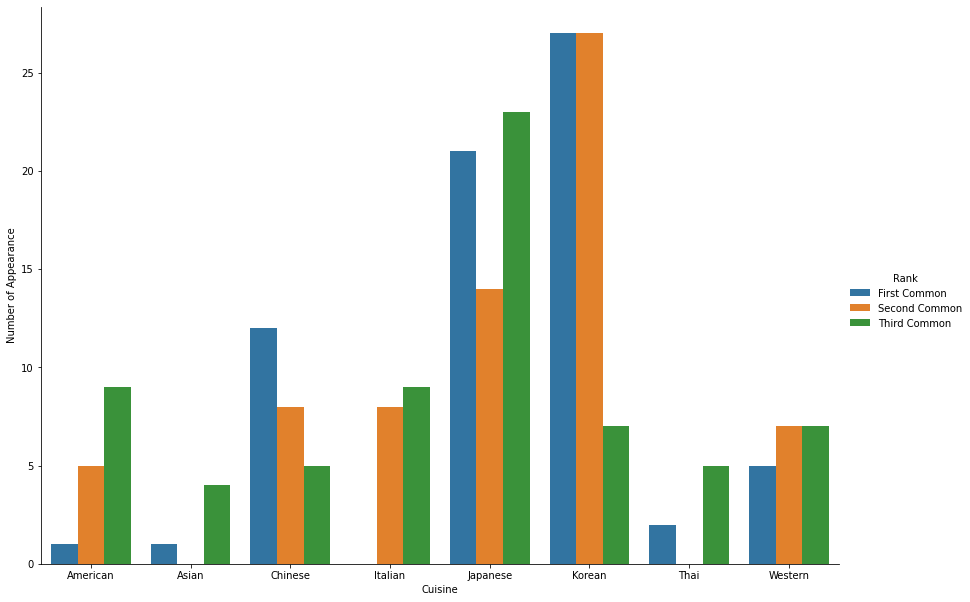

In [128]:
MakeRankChart('Common',0)

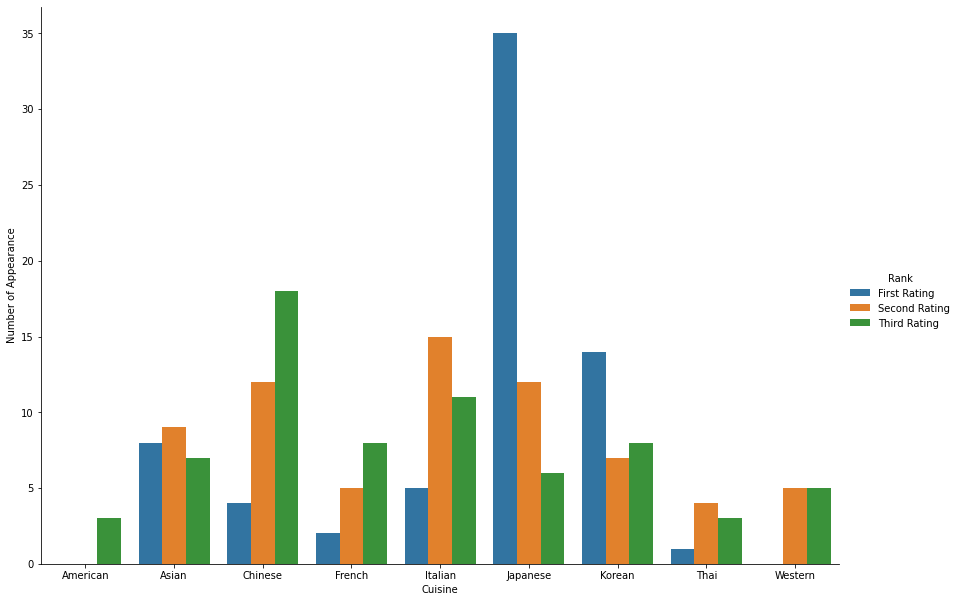

In [127]:
MakeRankChart('Rating',0)

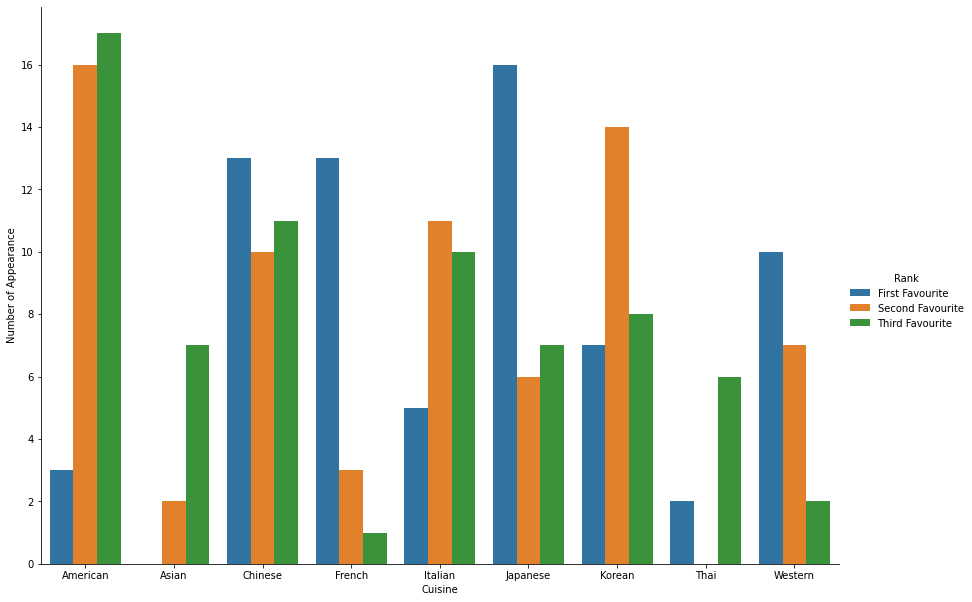

In [129]:
MakeRankChart('Favourite',0)

Cluster 1: Crowded areas of the city, which have a lot of Asian restaurants (Japanese, Korean, Chinese) which have some common ground with Vietnamese. Restaurants in those areas usually serve family dining or affordable meal for students.

#### Cluster 2

In [ ]:
restaurant_cluster.loc[restaurant_cluster['Cluster Labels'] == 1, restaurant_cluster.columns[[0] + list(range(4, restaurant_cluster.shape[1]))]]

,Pin,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,1st Most Rating Cuisine,2nd Most Rating Cuisine,3rd Most Rating Cuisine,1st Most Favourite Cuisine,2nd Most Favourite Cuisine,3rd Most Favourite Cuisine
6,"Nguyen Trung Truc, Ba Dinh, Ha Noi (21.04264, ...",Korean,International,American,American,Chinese,International,International,Korean,Chinese
7,"Phuc Xa, Ba Dinh, Ha Noi (21.04695, 105.84897)",Korean,International,Chinese,Chinese,International,American,Korean,International,Chinese
8,"Quan Thanh, Ba Dinh, Ha Noi (21.03980, 105.84086)",Korean,Western,International,Western,Chinese,International,International,Korean,Western
10,"Truc Bach, Ba Dinh, Ha Noi (21.04649, 105.84048)",Korean,Chinese,Western,French,Western,Chinese,French,International,Korean
11,"Vinh Phuc, Ba Dinh, Ha Noi (21.04284, 105.80912)",Japanese,International,Western,Western,Japanese,International,Western,International,Japanese
...,...,...,...,...,...,...,...,...,...,...
274,"Hoa Thanh, Tan Phu, Ho Chi Minh (10.77827, 106...",Japanese,American,Asian,Asian,Japanese,American,Japanese,American,Asian
275,"Phu Thanh, Tan Phu, Ho Chi Minh (10.77911, 106...",American,Japanese,Western,Western,Korean,Japanese,Korean,American,Japanese
276,"Phu Tho Hoa, Tan Phu, Ho Chi Minh (10.78515, 1...",Western,Korean,Japanese,Italian,Western,Japanese,Korean,Japanese,American
280,"Tan Son Nhi, Tan Phu, Ho Chi Minh (10.79893, 1...",Korean,Japanese,Italian,International,Italian,Western,International,Italian,Japanese


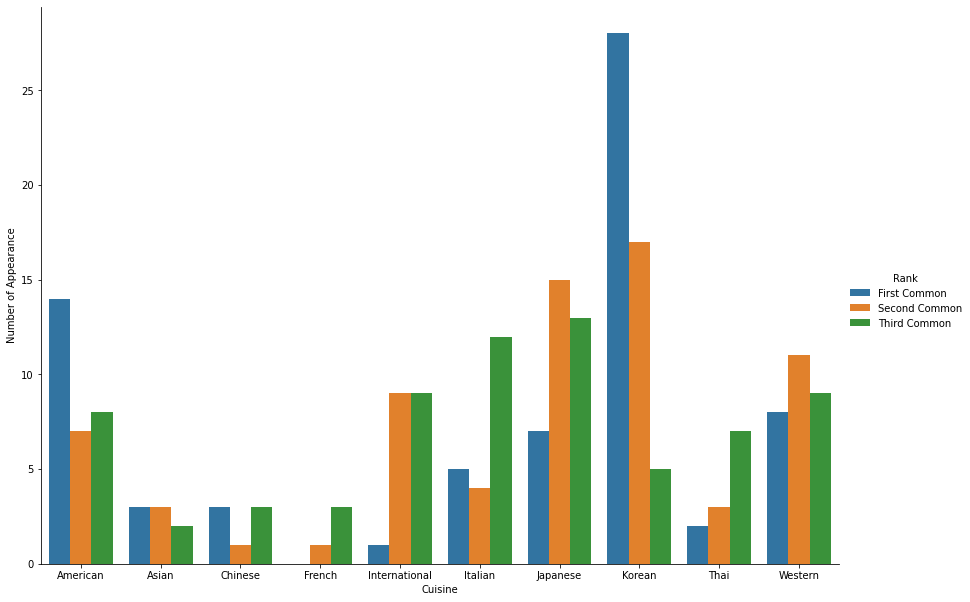

In [131]:
MakeRankChart('Common',1)

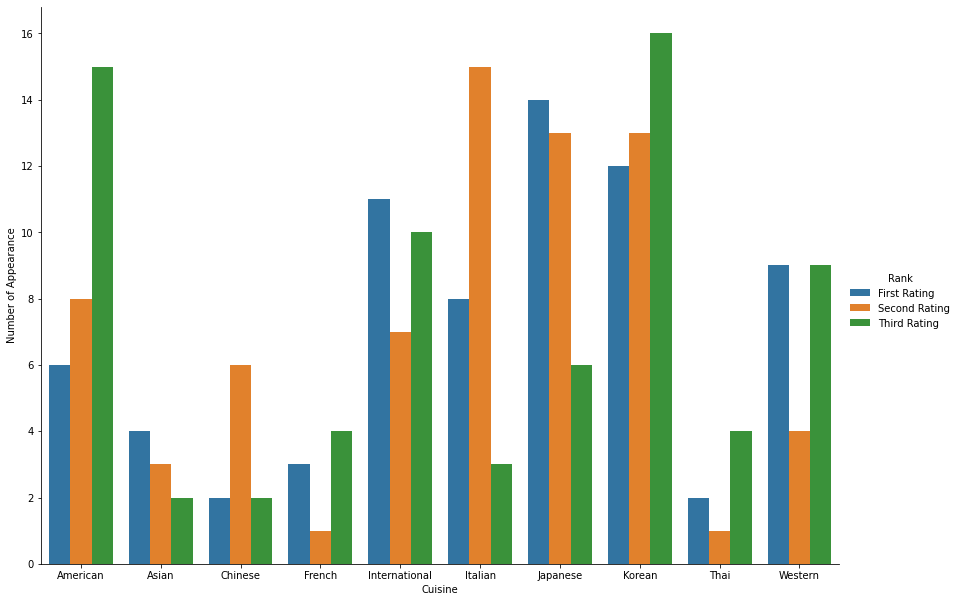

In [132]:
MakeRankChart('Rating',1)

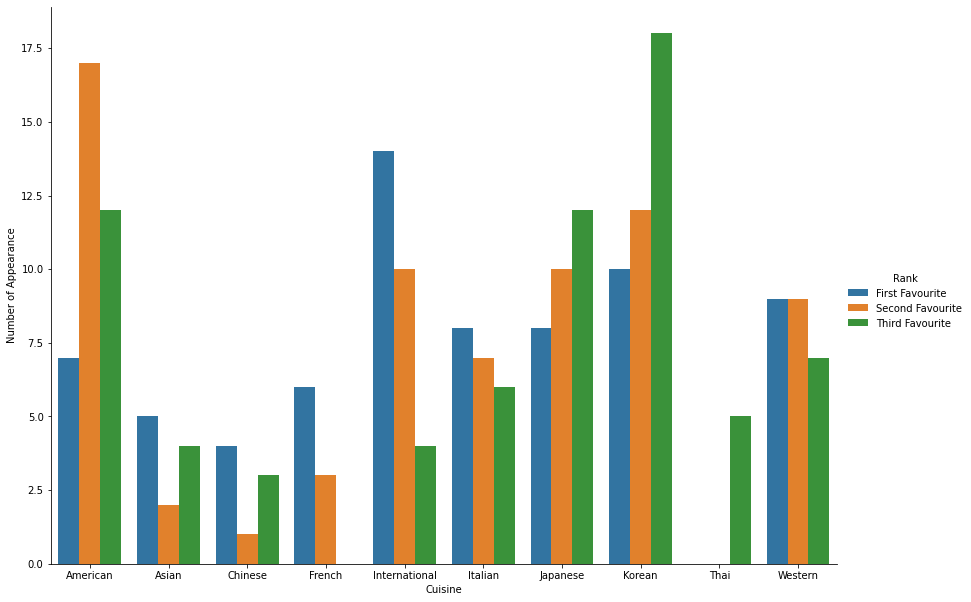

In [133]:
MakeRankChart('Favourite',1)

Cluster 2: Farthest areas from the city center which will not have many visiters or travelers. In my opinion, a lot of Korean and American restaurants here it fast food restaurants which serve fried chicken, burger like KFC, Lotteria.

#### Cluster 3

In [ ]:
restaurant_cluster.loc[restaurant_cluster['Cluster Labels'] == 2, restaurant_cluster.columns[[0] + list(range(4, restaurant_cluster.shape[1]))]]

,Pin,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,1st Most Rating Cuisine,2nd Most Rating Cuisine,3rd Most Rating Cuisine,1st Most Favourite Cuisine,2nd Most Favourite Cuisine,3rd Most Favourite Cuisine
4,"Ngoc Ha, Ba Dinh, Ha Noi (21.03872, 105.82751)",Japanese,Western,Asian,Japanese,Western,Thai,Western,Italian,Japanese
13,"Doi Can, Ba Dinh, Ha Noi (21.03527, 105.82655)",Japanese,Asian,Western,Japanese,Asian,Thai,Western,Italian,International
15,"Dich Vong Hau, Cau Giay, Ha Noi (21.03551, 105...",Korean,Japanese,International,Chinese,Japanese,International,International,American,Italian
37,"Vinh Tuy, Hai Ba Trung, Ha Noi (20.99845, 105....",Japanese,Korean,Italian,Western,Japanese,Asian,Asian,Japanese,Korean
60,"Mai Dong, Hoang Mai, Ha Noi (20.99150, 105.86436)",Japanese,Korean,Italian,Asian,Western,Japanese,Japanese,Asian,Korean
63,"Vinh Hun, Hoang Mai, Ha Noi (20.99061, 105.87477)",Japanese,Italian,Korean,International,Asian,Western,Korean,Japanese,Asian
74,"Khuong Trung, Thanh Xuan, Ha Noi (20.99757, 10...",Korean,Japanese,International,American,International,Japanese,American,Italian,Korean
75,"Nhan Chinh, Thanh Xuan, Ha Noi (21.00221, 105....",Korean,Asian,Japanese,American,Korean,Asian,Western,American,Italian
79,"Thing Dinh, Thanh Xuan, Ha Noi (20.99963, 105....",Korean,International,Asian,Japanese,International,Italian,Western,Italian,Korean
88,"Lang Ha, Dong Da, Ha Noi (21.01690, 105.81139)",Japanese,Korean,Asian,American,Japanese,Western,Western,Chinese,Japanese


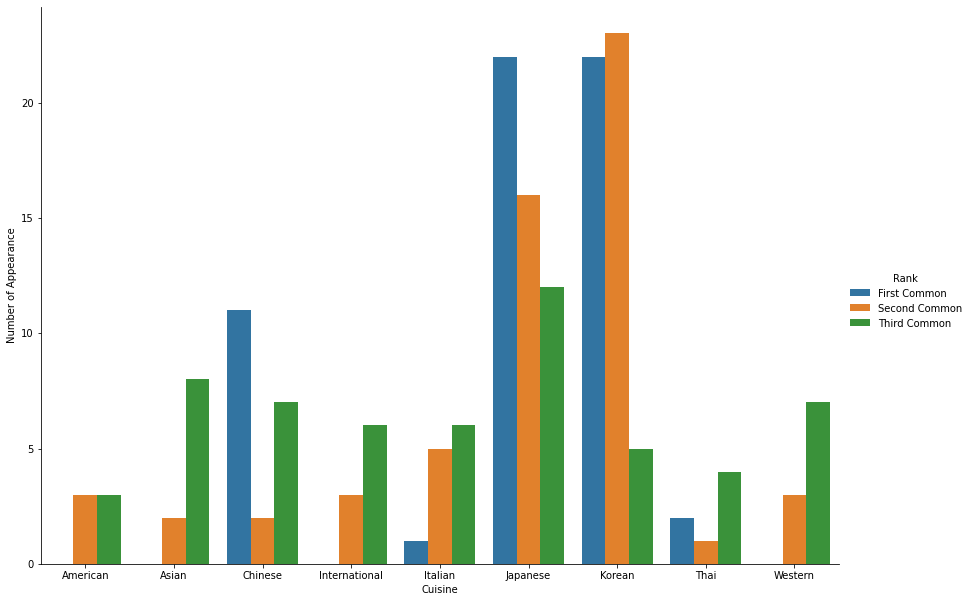

In [134]:
MakeRankChart('Common',2)

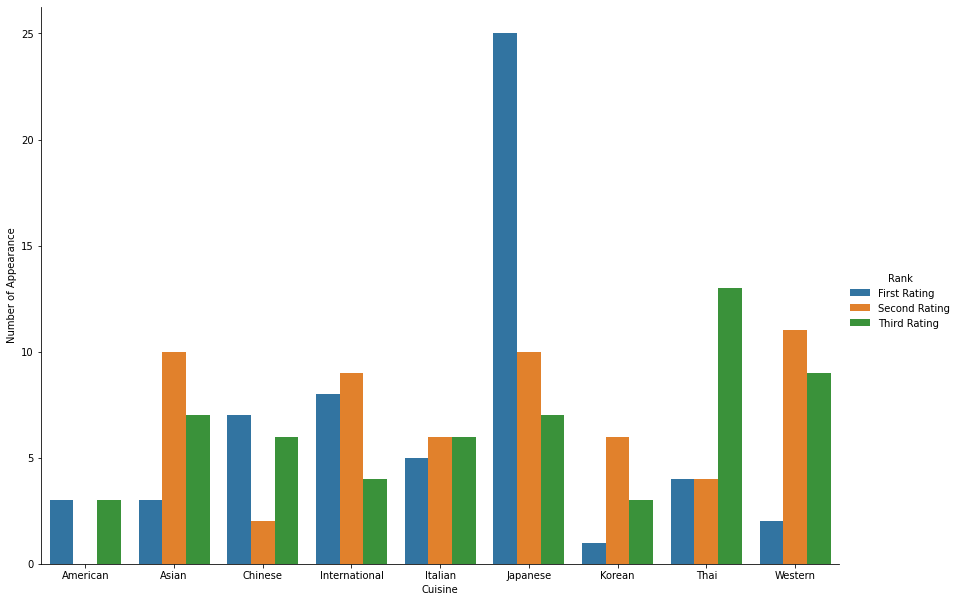

In [135]:
MakeRankChart('Rating',2)

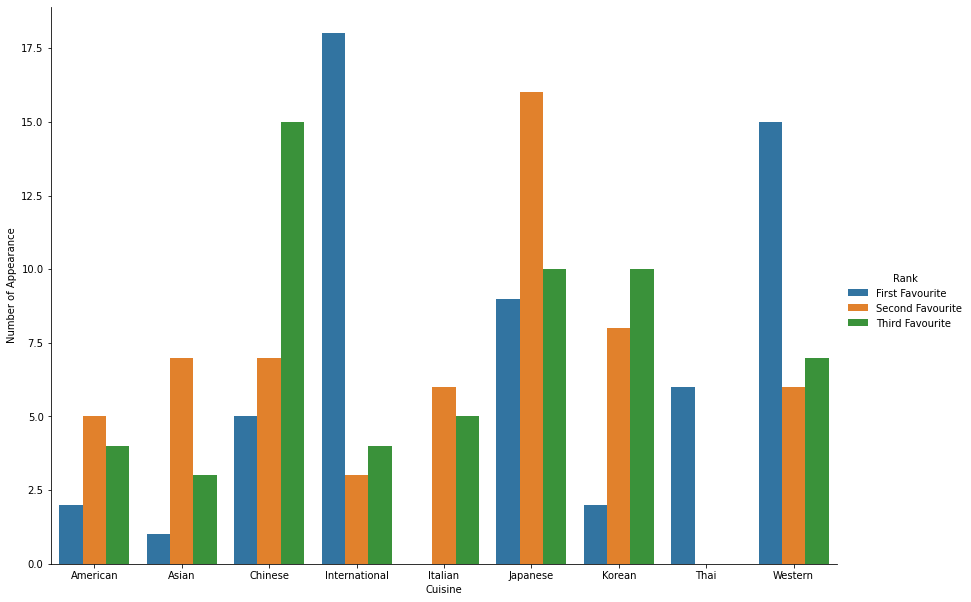

In [136]:
MakeRankChart('Favourite',2)

Cluster 3: Middle areas between cluster 4 and others, those areas cuisines is interference of other areas. Japanese and Western cuisines is safe choice here.

#### Cluster 4

In [ ]:
restaurant_cluster.loc[restaurant_cluster['Cluster Labels'] == 3, restaurant_cluster.columns[[0] + list(range(4, restaurant_cluster.shape[1]))]]

,Pin,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,1st Most Rating Cuisine,2nd Most Rating Cuisine,3rd Most Rating Cuisine,1st Most Favourite Cuisine,2nd Most Favourite Cuisine,3rd Most Favourite Cuisine
0,"Cong Vi, Ba Dinh, Ha Noi (21.03482, 105.80894)",Japanese,International,Korean,Asian,Chinese,French,Chinese,Italian,Japanese
1,"Giang Vo, Ba Dinh, Ha Noi (21.02755, 105.81743)",Japanese,Korean,International,Chinese,Japanese,Asian,French,Chinese,American
2,"Kim Ma, Ba Dinh, Ha Noi (21.03080, 105.82352)",Japanese,Korean,Asian,Chinese,French,Japanese,Western,French,Italian
3,"Lieu Giai, Ba Dinh, Ha Noi (21.03836, 105.81676)",Japanese,Korean,International,Asian,Chinese,French,Western,Chinese,Japanese
5,"Ngoc Khanh, Ba Dinh, Ha Noi (21.02963, 105.80883)",Japanese,Korean,International,American,Asian,Chinese,Chinese,Korean,American
...,...,...,...,...,...,...,...,...,...,...
195,"Quan 3, Quan 3, Ho Chi Minh (10.78064, 106.69119)",Japanese,Western,Korean,International,Western,Japanese,Korean,Italian,Western
196,"Quan 3, Quan 3, Ho Chi Minh (10.78393, 106.68615)",Japanese,Korean,Chinese,International,French,Italian,Korean,International,Western
197,"Quan 3, Quan 3, Ho Chi Minh (10.78885, 106.68633)",Japanese,French,Korean,American,International,Japanese,International,Korean,Italian
198,"Quan 3, Quan 3, Ho Chi Minh (10.78225, 106.67880)",Western,Japanese,Korean,Chinese,Japanese,Asian,Western,Chinese,French


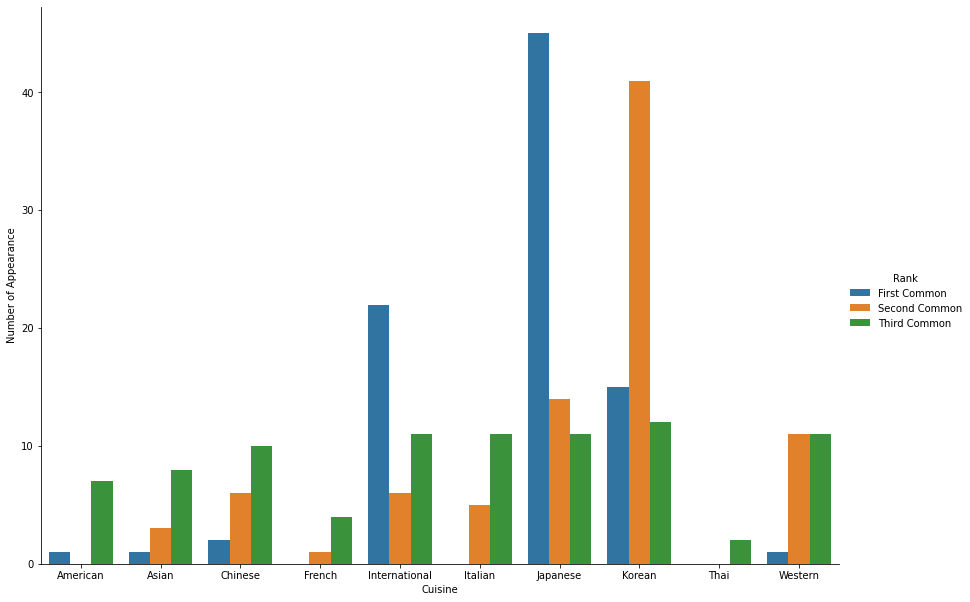

In [137]:
MakeRankChart('Common',3)

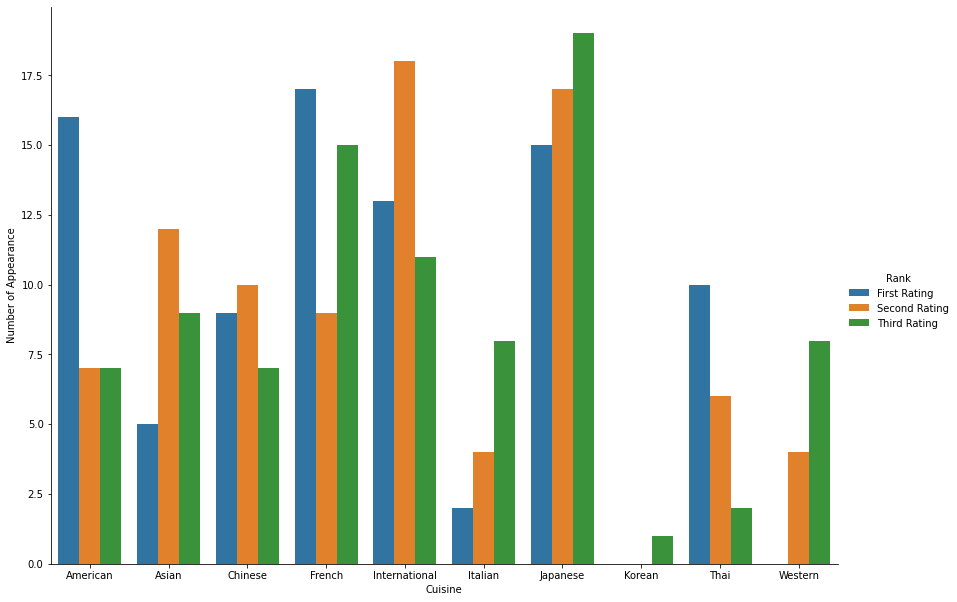

In [138]:
MakeRankChart('Rating',3)

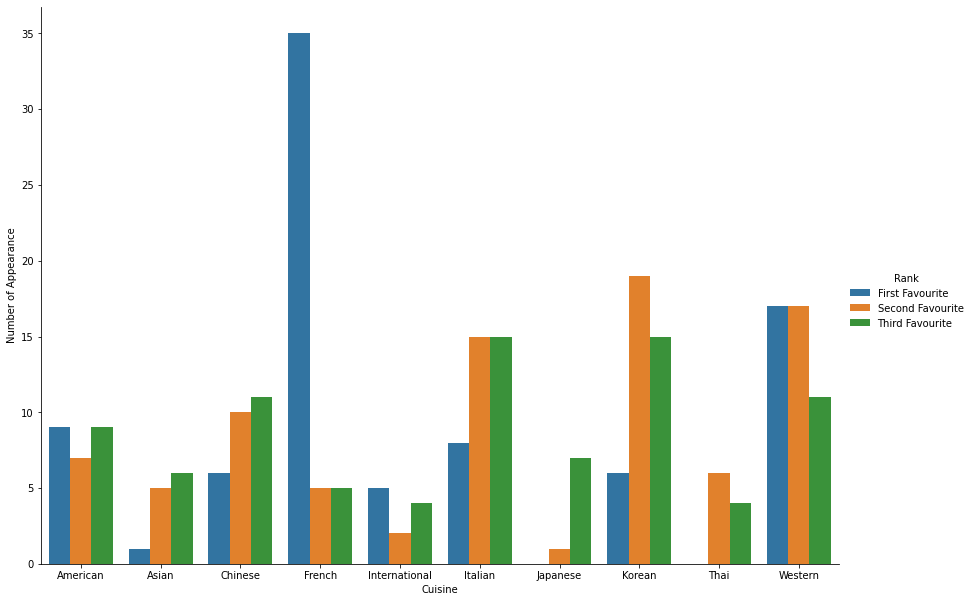

In [139]:
MakeRankChart('Favourite',3)

Cluster 4: In the center of the city, those areas contains many luxury, fine dining restaurants. Japanese and French restaurants got highest rating scores and Western, French cuisines is the most favourite. Open a high-end French restaurants for business lunch, office party, convention event will be the best choice.


In [ ]:
center_df = pd.DataFrame(data = kmeans.cluster_centers_, columns = restaurant_merged.columns[1:])
center_df.reset_index(inplace = True)
center_df

,index,American_percent,Asian_percent,Chinese_percent,French_percent,International_percent,Italian_percent,Japanese_percent,Korean_percent,Thai_percent,Western_percent,American_avgRating,Asian_avgRating,Chinese_avgRating,French_avgRating,International_avgRating,Italian_avgRating,Japanese_avgRating,Korean_avgRating,Thai_avgRating,Western_avgRating,American_avgFavourite,Asian_avgFavourite,Chinese_avgFavourite,French_avgFavourite,International_avgFavourite,Italian_avgFavourite,Japanese_avgFavourite,Korean_avgFavourite,Thai_avgFavourite,Western_avgFavourite
0,0,0.128712,0.074911,0.159503,3.532673e-02,-4.163336e-17,0.106274,0.203393,0.218018,0.019130,0.054732,5.982657,4.979469,5.623277,2.823913e+00,3.552714e-15,6.035447,7.467445,6.923321,1.410870,3.080469,0.128674,0.048992,0.176572,0.094479,5.551115e-17,0.112077,0.172613,0.131096,0.025800,0.109696
1,1,0.216115,0.043056,0.044277,2.300058e-02,8.500989e-02,0.094486,0.139963,0.234406,0.027459,0.092226,5.384038,1.221549,1.156573,9.577465e-01,3.702934e+00,3.057746,4.287011,5.551009,1.077465,2.853638,0.151934,0.050654,0.052029,0.050016,1.550496e-01,0.121878,0.122315,0.172030,0.012033,0.112062
2,2,0.082872,0.073588,0.137439,1.387779e-17,6.249908e-02,0.082830,0.226080,0.200815,0.066197,0.067680,5.964152,6.338547,5.922291,1.776357e-15,5.764990e+00,6.630460,7.628752,7.107501,6.222198,6.686710,0.076332,0.063751,0.136189,0.000000,1.515033e-01,0.077570,0.148430,0.102300,0.059976,0.183948
3,3,0.078973,0.086566,0.075947,5.463044e-02,1.281926e-01,0.074853,0.224921,0.161392,0.043285,0.071239,7.271604,7.142504,6.591873,7.521596e+00,6.742865e+00,7.013682,7.629589,7.114834,6.545249,6.861162,0.094920,0.078560,0.088673,0.169269,7.247943e-02,0.117040,0.073785,0.117300,0.055278,0.132695


Center of each cluster

In [ ]:
# create a new dataframe
center_sorted = pd.DataFrame(columns=columns)
center_sorted['Nearest pin'] = center_df['index']
center_sorted.rename({'Nearest pin':'Cluster'}, inplace = True)

center_df.shape[0]
for ind in np.arange(center_df.shape[0]):
    center_sorted.iloc[ind, 1:num_top_cuisines+1] = return_most_common_cuisines(center_df.iloc[ind,:], num_top_cuisines)
    center_sorted.iloc[ind, num_top_cuisines+1:num_top_cuisines*2+1] = return_most_rating_cuisines(center_df.iloc[ind,:], num_top_cuisines)
    center_sorted.iloc[ind, num_top_cuisines*2+1:] = return_most_favourite_cuisines(center_df.iloc[ind, :], num_top_cuisines)

center_sorted.replace('_percent','', regex = True, inplace = True)
center_sorted.replace('_avgRating','', regex = True, inplace = True)
center_sorted.replace('_avgFavourite','', regex = True, inplace = True)

center_sorted


,Nearest pin,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,1st Most Rating Cuisine,2nd Most Rating Cuisine,3rd Most Rating Cuisine,1st Most Favourite Cuisine,2nd Most Favourite Cuisine,3rd Most Favourite Cuisine
0,0,Korean,Japanese,Chinese,Japanese,Korean,Italian,Chinese,Japanese,Korean
1,1,Korean,American,Japanese,Korean,American,Japanese,Korean,International,American
2,2,Japanese,Korean,Chinese,Japanese,Korean,Western,Western,International,Japanese
3,3,Japanese,Korean,International,Japanese,French,American,French,Western,Korean


## Results and Discussion <a name="results"></a>

Our analysis was go through more than 2000 restaurants in Ha Noi and Ho Chi Minh to find out what kind of restaurants is popular in each areas of two cities above. <br><br>
For luxury restaurants for high-end customers, business lunchs or office parties, convention events it should be located in the city center, such as Hoan Kiem District in Ha Noi, District 1, 3 in Ho Chi Minh City. French and Japanese food will be love in those areas. <br><br>
In crowded neighborhood with a lot of residents and students (Ha Noi: Hoang Mai District , Ho Chi Minh city: District 8, Dictrict 11, Thu Duc District), Korean and Italian restaurants which affordable price will take advantage here. <br><br>
In the area far from city center, it won't be a lot of restaurants there, mostly some American and Korean Fried chicken restaurants in those area.